In [1]:
import numpy as np
import pandas as pd
import s3fs
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Concatenate
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from typing import List, Set, Dict, Tuple, Optional, Iterable, Callable
import pyarrow
import boto3
import pyarrow.parquet as pq
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report, average_precision_score, 
                             precision_recall_curve, auc, roc_auc_score, plot_precision_recall_curve, plot_roc_curve)
from matplotlib import pyplot as plt

In [2]:
pd.options.display.float_format = '{:20,.3f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.max_colwidth', 0)
s3 = s3fs.S3FileSystem()

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # wide notebook display

In [4]:
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
physical_device = tensorflow.config.experimental.list_physical_devices('GPU')
print(f'Device found : {physical_device}')

Device found : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))
tensorflow.test.is_gpu_available()
!python3 --version

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1307139649211273004
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15345647616
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2063539672822525188
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0"
xla_global_id: 416903419
]
2.7.0
Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Python 3.7.10


In [7]:
feature_path = 's3://aap-aiexpzone-pii-mktg-datascientist-results-prod/ScottSmith/may_2021_page_action_no_leakage.parquet'

In [8]:
feature_table = pq.ParquetDataset(feature_path, filesystem=s3).read_pandas().to_pandas()

In [9]:
len(feature_table)

5800999

In [10]:
feature_table.columns

Index(['udo_tealium_session_id', 'TYPE_SENTENCE', 'NAME_SENTENCE',
       'CATEGORY_SENTENCE', 'ACTION_SENTENCE', 'LABEL_SENTENCE',
       'DWELL_SENTENCE', 'LABEL'],
      dtype='object')

In [11]:
feature_table.dtypes

udo_tealium_session_id    object
TYPE_SENTENCE             object
NAME_SENTENCE             object
CATEGORY_SENTENCE         object
ACTION_SENTENCE           object
LABEL_SENTENCE            object
DWELL_SENTENCE            object
LABEL                     int32 
dtype: object

In [12]:
len(feature_table.iloc[0, 1].split())

14

### Now we evaluate the class balance

In [13]:
summary = feature_table.groupby('LABEL')['udo_tealium_session_id'].count().reset_index()

In [14]:
summary['FRACTION'] = summary['udo_tealium_session_id']/summary['udo_tealium_session_id'].sum()

In [15]:
summary

LABEL  udo_tealium_session_id             FRACTION
0  0      5491530                               0.947
1  1      309469                                0.053

### Let's look at sequence sizes

In [16]:
feature_table['LENGTH'] = feature_table['TYPE_SENTENCE'].str.split().apply(len)

In [17]:
true_zeros = feature_table[feature_table.LABEL == 0]

In [18]:
true_ones = feature_table[feature_table.LABEL == 1]

In [19]:
true_zeros['LENGTH'].mean()

4.658221479259878

In [20]:
true_ones['LENGTH'].mean()

5.328643579809286

In [21]:
true_ones['NAME_SENTENCE'].head(100)

26      EvaporativeEmissionsVacuumSolenoidValve, VacuumsolenoidResults, VacuumsolenoidResults, VacuumsolenoidvacuumResults, VacuumResults                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
71      Homepage, Homepage, thermostatsResults, thermostatssensorResults, coolanttemperaturesensorResults, StoreLocator, temperaturesensorsResults                                    

In [22]:
true_zeros['ACTION_SENTENCE'].head(100)

0      ASSYLUBE, Page, Page, ASSYLUBEGREASE, Page, Page, Page, ENGINEASSYLUBEGREASE, Page, Page, LUBERPLATEGREASE, Page, Page, l0034094                                                                                                                                                                                                                                                               
1      Garage, Garage, Garage, Garage, Garage, Garage, Garage                                                                                                                                                                                                                                                                                                                                         
2      rearbrakepads, rearbrake, Page                                                                                                                                                                                     

#### We want the mean sequence lengths of true positives and negatives to be as close as possible to each other to avoid the model over relying on sequence length.

In [23]:
(true_zeros['LENGTH']==1).sum()/len(true_zeros)

0.18485085213046273

In [24]:
(true_ones['LENGTH']==1).sum()/len(true_ones)

0.1678843438276532

In [25]:
(true_zeros['LENGTH']==2).sum()/len(true_zeros)

0.171771619202663

In [26]:
(true_ones['LENGTH']==2).sum()/len(true_ones)

0.12287498909422269

In [27]:
(true_zeros['LENGTH']==3).sum()/len(true_zeros)

0.15492895422587147

In [28]:
(true_ones['LENGTH']==3).sum()/len(true_ones)

0.12310764567694987

#### Although the true negatives are shorter, the differcence should not impact the model very much

### Now we filter our data so that the minimum sequence length is seven.  This will prevent the model from learning that longer sequences have a higher probablity of conversion

In [29]:
feature_table_reduced = feature_table[feature_table.LENGTH >=7]

In [30]:
len(feature_table_reduced)

1239841

### First we do a train/test stratified split. We must do this prior to creating dictionaries.  In fact, we need to go back to the spark notebook and fix the defintion of dwell buckets rather than determine them using all data

### Split data into list of labels and 5 lists of features

In [ ]:
y_train = y_train.tolist()
y_test = y_test.tolist()

In [ ]:
test = tokenizer.texts_to_sequences(X_train_category)

#### Now we fut everything into fuctions

In [45]:
def process_sentences(sentence_series: pd.Series,
                      maxlen: int, 
                      padding: str = 'pre', 
                      truncating: str ='post',
                      tokenizer: Tokenizer = None,
                      num_words: int = None,) -> np.array:
    """Function to use a fit tokenizer to convert a pandas series of sentences into a numpy array
    of integers.  This numpy array will have the same number of rows as elements of the sentence
    series and maxlen number of columns. This matrix will represent each word in the sequence by an 
    integer, with 1 standing for the UNKNOWN token, 0 for padding, and numbers representing the 
    vocabulary size defined by fit_tokenizer.
    
    Parameters
    ----------
     sentence_series: pd.Series
        A series of text elements, each containing a sentence of words separated by spaces
         
     maxlen: int
         The maximum number of words in a sentence to be kept
         
     padding: str
         If 'pre', the sentences are left padded with 0 values if less than maxlen
         if 'post' the sentences are right padded with 0 values if less than maxlen
         
     truncating: str
         If 'pre', the sentences are truncated from the left if greater than maxlen.
         This keeps the earliest sequence values
         if 'post' the sentences are truncated from the right if greater than maxlen.
         This keeps the latest sequence values
         
     tokenizer: Tokenizer
         A fit Tokenizer object. If none, a new tokenizer will be fit on the data
         
     num_words: int
         The number of words to be in the vocabulary for this sequence.  This must
         be specified if fit_tokenizer is None.
    
    Returns
    -------
    A numpy array of containing a row for each sequence and a column for each token. The
    second dimension is always maxlen.
    """
    # Convert the series of sentences to a list
    sentence_list = sentence_series.tolist()
    
    # Fit the fit tokenizer if necessary
    if tokenizer is None:
        tokenizer = Tokenizer(
            num_words=num_words,
            filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
            lower=True, 
            split=', ', 
            char_level=False, 
            oov_token="UNKNOWN")
        tokenizer.fit_on_texts(sentence_list)
    
    # Create the sequences of indicies
    sequences = tokenizer.texts_to_sequences(sentence_list)
    
    # Truncate and pad the sequences
    output = pad_sequences(sequences, maxlen=maxlen, padding=padding, truncating=truncating)
    
    return output, tokenizer   

### Let's only use 10% of the data

In [31]:
feature_table_subset = feature_table.groupby('LABEL').sample(frac=0.1, random_state=3)

In [32]:
len(feature_table), len(feature_table_subset)

(5800999, 580100)

### Now split the data into train and test

In [33]:
X_train, X_test, y_train, y_test = train_test_split(feature_table_subset[['TYPE_SENTENCE', 'NAME_SENTENCE', 'CATEGORY_SENTENCE', 'ACTION_SENTENCE', 'LABEL_SENTENCE', 'DWELL_SENTENCE']], 
                                                    feature_table_subset['LABEL'], 
                                                    test_size=0.10, random_state=1, stratify=feature_table_subset['LABEL'])

In [34]:
X_train.head(10)

TYPE_SENTENCE  \
5335719  home, home, reactsearch, search, search                                                  
2030801  PRODUCT, PRODUCT, PRODUCT, PRODUCT                                                       
5431150  PRODUCT, PRODUCT                                                                         
2011192  PRODUCT, PRODUCT, PRODUCT, PRODUCT, PRODUCT                                              
3798751  home, home                                                                               
4736264  L3, L3, L3                                                                               
5346230  PRODUCT, PRODUCT, PRODUCT, PRODUCT, PRODUCT, PRODUCT, PRODUCT, PRODUCT, PRODUCT, store   
3025584  PRODUCT, PRODUCT                                                                         
5200633  reactsearch, reactsearch, L3, L3, L3                                                     
1198850  PRODUCT, PRODUCT                                                                         

                                                                                                                                                                                                                                                                                                                        NAME_SENTENCE  \
5335719  Homepage, Homepage, reactsearch, finalclearancepromoResults, hvacblowerfansensorResults                                                                                                                                                                                                                                        
2030801  9005SilverStarzXeHalogenBulbPackof2, 9005SilverStarzXeHalogenBulbPackof2, 9005SilverStarzXeHalogenBulbPackof2, 9005SilverStarzXeHalogenBulbPackof2                                                                                                                                                                             
5431150  LaserIridiumSparkPlugLZFR5CI11, LaserIridiumSparkPlugLZFR5CI11                                                                                                                                                                                                                                                                 
2011192  3157NALongLifeMiniBulbPackof2, 3157NALongLifeMiniBulbPackof2, 3157NALongLifeMiniBulbPackof2, 3157NALongLifeMiniBulbPackof2, 3157LongLifeMiniBulbPackof2                                                                                                                                                                        
3798751  Homepage, Homepage                                                                                                                                                                                                                                                                                                             
4736264  DoorHandleampPartsResults, DoorHandleampPartsResults, DoorHandleampPartsResults                                                                                                                                                                                                                                                
5346230  AutomaticTransmissionBasicRebuildKit, AutomaticTransmissionBasicRebuildKit, AutomaticTransmissionBasicRebuildKit, AutomaticTransmissionBasicRebuildKit, AutomaticTransmissionBasicRebuildKit, ATMASTERREPAIRKIT, AutomaticTransmissionBasicRebuildKit, AutomaticTransmissionBasicRebuildKit, ATMASTERREPAIRKIT, StoreDetails   
3025584  NewCompressorwithClutch, NewCompressorwithClutch                                                                                                                                                                                                                                                                               
5200633  reactsearch, reactsear

### Split data into list of labels and 5 lists of features

In [35]:
X_train_type = X_train['TYPE_SENTENCE'].tolist()
X_test_type = X_test['TYPE_SENTENCE'].tolist()
X_train_name = X_train['NAME_SENTENCE'].tolist()
X_test_name = X_test['NAME_SENTENCE'].tolist()
X_train_category = X_train['CATEGORY_SENTENCE'].tolist()
X_test_category = X_test['CATEGORY_SENTENCE'].tolist()
X_train_action = X_train['ACTION_SENTENCE'].tolist()
X_test_action = X_test['ACTION_SENTENCE'].tolist()
X_train_label = X_train['LABEL_SENTENCE'].tolist()
X_test_label = X_test['LABEL_SENTENCE'].tolist()
X_train_dwell = X_train['DWELL_SENTENCE'].tolist()
X_test_dwell = X_test['DWELL_SENTENCE'].tolist()

In [36]:
X_train_type[0]

'home, home, reactsearch, search, search'

In [37]:
X_train_name[0]

'Homepage, Homepage, reactsearch, finalclearancepromoResults, hvacblowerfansensorResults'

In [38]:
X_train_label[0]

'2000ChevroletSilverado1500LS53L5328CCV8FIVINTLM7, finalclearancepromo, 2000ChevroletSilverado1500LS53L5328CCV8FIVINTLM7, 2000ChevroletSilverado1500LS53L5328CCV8FIVINTLM7, 2000ChevroletSilverado1500LS53L5328CCV8FIVINTLM7'

In [39]:
X_train_dwell[0]

'80, 20, 70, 90, 90'

In [40]:
y_train.head()

5335719    0
2030801    0
5431150    0
2011192    1
3798751    1
Name: LABEL, dtype: int32

In [ ]:
tokenizer = Tokenizer(
    num_words=400,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, 
    split=', ', 
    char_level=False, 
    oov_token="UNKNOWN")

### Prepare sequences for modeling.  Note that we pass the fit tokenizer when we prepare the test sequences

#### We create an empty dictionary.  The keys will be the sentence name, the values will be the train and test indicies

In [41]:
data_dict = {}

In [43]:
vocab_size_dict = {'TYPE_SENTENCE': 50,
                   'NAME_SENTENCE': 40000,
                   'CATEGORY_SENTENCE': 1900,
                   'ACTION_SENTENCE': 20000,
                   'LABEL_SENTENCE': 40000,
                   'DWELL_SENTENCE': 11
                  }

In [46]:
for column_name, size in vocab_size_dict.items():
    print(f'Starting {column_name} with size {size}')
    data_dict[column_name] = {}
    data_dict[column_name]['train'], fit_tokenizer = process_sentences(sentence_series=X_train[column_name], maxlen=7, num_words=size)
    data_dict[column_name]['test'], _ = process_sentences(sentence_series=X_test[column_name], maxlen=7, tokenizer=fit_tokenizer)
    

Starting TYPE_SENTENCE with size 50
Starting NAME_SENTENCE with size 40000
Starting CATEGORY_SENTENCE with size 1900
Starting ACTION_SENTENCE with size 20000
Starting LABEL_SENTENCE with size 40000
Starting DWELL_SENTENCE with size 11


In [47]:
data_dict['DWELL_SENTENCE']['train'][:10]

array([[ 0,  0,  1,  8,  5,  6,  6],
       [ 0,  0,  0,  1,  2,  5,  6],
       [ 0,  0,  0,  0,  0,  1,  7],
       [ 0,  0,  1,  5,  2,  6,  9],
       [ 0,  0,  0,  0,  0,  1,  9],
       [ 0,  0,  0,  0,  1,  8, 10],
       [ 1, 10,  5,  2,  3,  5,  2],
       [ 0,  0,  0,  0,  0,  1,  6],
       [ 0,  0,  1,  7, 10,  2,  7],
       [ 0,  0,  0,  0,  0,  1,  7]], dtype=int32)

In [48]:
data_dict['TYPE_SENTENCE']['train'][:10]

array([[ 0,  0,  5,  4,  9,  2,  2],
       [ 0,  0,  0,  7,  3,  3,  3],
       [ 0,  0,  0,  0,  0,  7,  3],
       [ 0,  0,  7,  3,  3,  3,  3],
       [ 0,  0,  0,  0,  0,  5,  4],
       [ 0,  0,  0,  0, 10,  6,  6],
       [ 7,  3,  3,  3,  3,  3,  3],
       [ 0,  0,  0,  0,  0,  7,  3],
       [ 0,  0, 12,  9,  6,  6,  6],
       [ 0,  0,  0,  0,  0,  7,  3]], dtype=int32)

In [49]:
data_dict['ACTION_SENTENCE']['train'][:10]

array([[    0,     0, 17855,    15,    54,  5802,  5802],
       [    0,     0,     0,     4,    32,     2,     2],
       [    0,     0,     0,     0,     0,     4,     2],
       [    0,     0,     4,     2,     2,    25,    10],
       [    0,     0,     0,     0,     0,     4,   306],
       [    0,     0,     0,     0,    14,     3,     3],
       [    4,     2,     2,     2,    25,    13,    13],
       [    0,     0,     0,     0,     0,    18,    16],
       [    0,     0,   102,    41,    21,     2,     2],
       [    0,     0,     0,     0,     0,    22,     2]], dtype=int32)

In [50]:
data_dict['LABEL_SENTENCE']['train'][:10]

array([[    0,     0,  1852,   109,   218,   218,   218],
       [    0,     0,     0,     9,     1,     4,     6],
       [    0,     0,     0,     0,     0,     9,     4],
       [    0,     0,     9,     4,     6,  7747,    13],
       [    0,     0,     0,     0,     0,    27,  3814],
       [    0,     0,     0,     0,    17,     2,     7],
       [    9,     4,    11,     6,     1,    16,    16],
       [    0,     0,     0,     0,     0,     1,     1],
       [    0,     0,  3675,    19,    31,    21,     4],
       [    0,     0,     0,     0,     0, 38410,     4]], dtype=int32)

In [51]:
data_dict['NAME_SENTENCE']['train'][:10]

array([[    0,     0,     3,     2,     4,    22, 11327],
       [    0,     0,     0,     1, 12110, 12110, 12110],
       [    0,     0,     0,     0,     0,   550,   257],
       [    0,     0,  7827,  3879,  3879,  3879,   442],
       [    0,     0,     0,     0,     0,     3,     2],
       [    0,     0,     0,     0,   681,   359,   359],
       [ 2106,  1252,  1252,  1252,  1252,  5274,  1252],
       [    0,     0,     0,     0,     0,   512,   104],
       [    0,     0,     8,     4,    16,    16,    16],
       [    0,     0,     0,     0,     0,    52,    19]], dtype=int32)

In [ ]:
data_dict['CATEGORY_SENTENCE']['train'][:10]

#### Next we create a Tokenizer object with a vocab size of 4000 to start.  We convert all words to lower case.

#### Next, we fit the tokenizer to the training set.  This creates the vocabulary and lookup dictionaries

#### Next we create the X_train numpy array of word indices for page name and event action

#### Next we create the X_test numpy arrray of word indices.  Note that we still use the tokenizer fit to the training set

### Our data is now fully prepared.  We now begin our modeling in keras

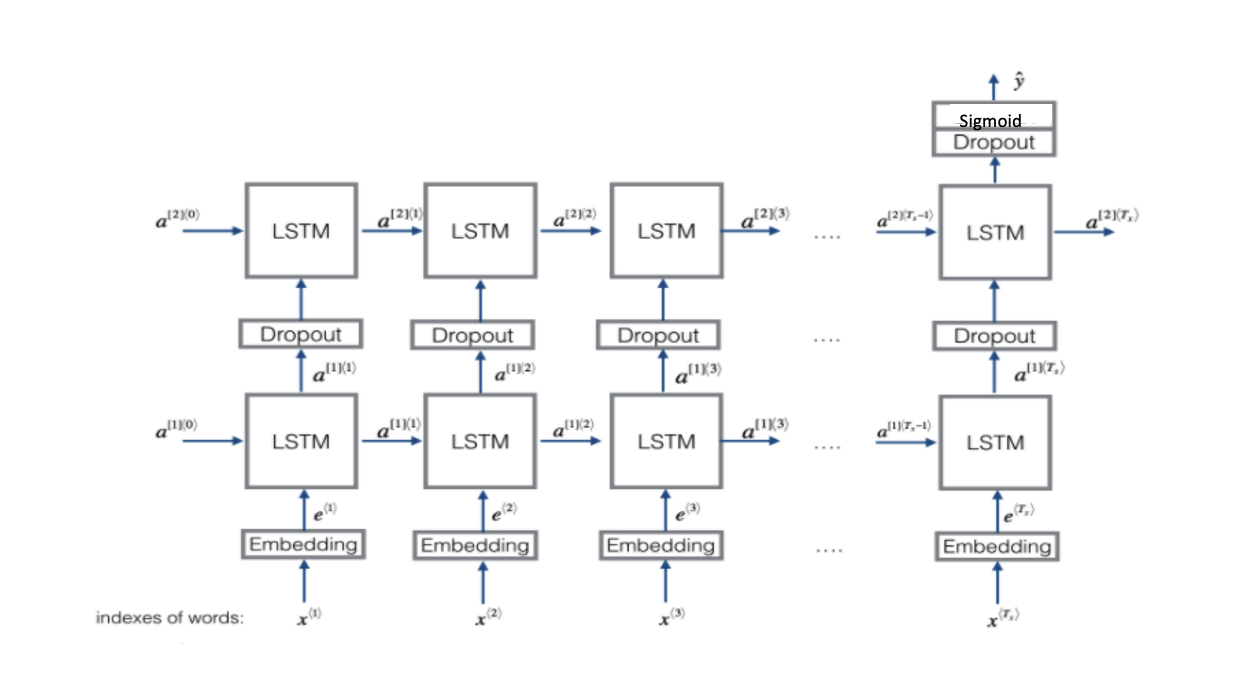

#### Above is our architecure.  We will add all layers in the architecure, but to start we will set dropout to 0.0 to start and try to minimze the training error

In [52]:
def ClickStreamPageModel(input_shape):
    """
    Function creating the click stream model using page names per the graph above
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the model
    name_sentence_indices = Input(shape=input_shape, dtype='int32')
    action_sentence_indicies = Input(shape=input_shape, dtype='int32')
    label_sentence_indicies = Input(shape=input_shape, dtype='int32')
    dwell_sentence_indicies = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layers and propogate the input through these, then append these to create a 57 dimension input
    name_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(name_sentence_indices)
    action_emb = Embedding(input_dim=20001, output_dim=25, trainable=True, mask_zero=True)(action_sentence_indicies)
    label_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(label_sentence_indicies)
    dwell_emb = Embedding(input_dim=12, output_dim=2, trainable=True, mask_zero=True)(dwell_sentence_indicies)
    X = Concatenate()([name_emb, action_emb, label_emb, dwell_emb])
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units=128, return_sequences=True)(X)
    
    # Add dropout with a probability of 0.4
    X = Dropout(rate=0.4)(X)
    
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units=128, return_sequences=False)(X)
    
    # Add dropout with a probability of 0.4
    X = Dropout(rate=0.4)(X) 
    
    # Propagate X through a Dense layer with 1 unit
    X = Dense(units=1)(X)
    # Add a sigmod activation
    X = Activation('sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[name_sentence_indices, action_sentence_indicies, label_sentence_indicies, dwell_sentence_indicies], outputs=X)
    
    return model

In [53]:
model = ClickStreamPageModel(7)

In [54]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 7)]          0           []                               
                                                                                              

In [55]:
aupr = tensorflow.keras.metrics.AUC(
    num_thresholds=50,
    curve="PR",
    summation_method="interpolation",
    name='aupr',
    dtype=None,
    thresholds=None,
    multi_label=False,
    num_labels=None,
    label_weights=None,
    from_logits=False,
)

In [56]:
model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-5), metrics=[aupr, 'accuracy'])

In [57]:
model.fit([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train']], 
           y_train, epochs = 100, 
           batch_size = 32, 
           shuffle=True, 
           validation_split=0.5)

Epoch 1/100
8158/8158 [==============================] - 552s 66ms/step - loss: 0.3508 - aupr: 0.0513 - accuracy: 0.9462 - val_loss: 0.2252 - val_aupr: 0.0686 - val_accuracy: 0.9463
Epoch 2/100
8158/8158 [==============================] - 540s 66ms/step - loss: 0.2049 - aupr: 0.0876 - accuracy: 0.9470 - val_loss: 0.1957 - val_aupr: 0.1174 - val_accuracy: 0.9462
Epoch 3/100
8158/8158 [==============================] - 540s 66ms/step - loss: 0.1909 - aupr: 0.1323 - accuracy: 0.9469 - val_loss: 0.1900 - val_aupr: 0.1444 - val_accuracy: 0.9462
Epoch 4/100
8158/8158 [==============================] - 540s 66ms/step - loss: 0.1856 - aupr: 0.1563 - accuracy: 0.9469 - val_loss: 0.1872 - val_aupr: 0.1585 - val_accuracy: 0.9461
Epoch 5/100
8158/8158 [==============================] - 541s 66ms/step - loss: 0.1818 - aupr: 0.1742 - accuracy: 0.9468 - val_loss: 0.1856 - val_aupr: 0.1668 - val_accuracy: 0.9461
Epoch 6/100
8158/8158 [==============================] - 540s 66ms/step - loss: 0.1783 - a

Epoch 46/100
8158/8158 [==============================] - 537s 66ms/step - loss: 0.1202 - aupr: 0.5431 - accuracy: 0.9567 - val_loss: 0.2729 - val_aupr: 0.1117 - val_accuracy: 0.9265
Epoch 47/100
8158/8158 [==============================] - 537s 66ms/step - loss: 0.1194 - aupr: 0.5490 - accuracy: 0.9571 - val_loss: 0.2757 - val_aupr: 0.1111 - val_accuracy: 0.9259
Epoch 48/100
3006/8158 [==========>...................] - ETA: 4:53 - loss: 0.1185 - aupr: 0.5701 - accuracy: 0.9574

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8158/8158 [==============================] - 539s 66ms/step - loss: 0.1188 - aupr: 0.5533 - accuracy: 0.9575 - val_loss: 0.2777 - val_aupr: 0.1099 - val_accuracy: 0.9248
Epoch 49/100
  73/8158 [..............................] - ETA: 7:40 - loss: 0.1046 - aupr: 0.5489 - accuracy: 0.9645

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6872/8158 [========================>.....] - ETA: 1:13 - loss: 0.1179 - aupr: 0.5608 - accuracy: 0.9579

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5515/8158 [===================>..........] - ETA: 2:30 - loss: 0.1169 - aupr: 0.5636 - accuracy: 0.9578

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4183/8158 [==============>...............] - ETA: 3:48 - loss: 0.1161 - aupr: 0.5723 - accuracy: 0.9581

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8158/8158 [==============================] - 539s 66ms/step - loss: 0.1164 - aupr: 0.5698 - accuracy: 0.9582 - val_loss: 0.2868 - val_aupr: 0.1077 - val_accuracy: 0.9260
Epoch 52/100
2795/8158 [=========>....................] - ETA: 5:06 - loss: 0.1148 - aupr: 0.5695 - accuracy: 0.9589

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8158/8158 [==============================] - 535s 66ms/step - loss: 0.1158 - aupr: 0.5729 - accuracy: 0.9586 - val_loss: 0.2895 - val_aupr: 0.1081 - val_accuracy: 0.9263
Epoch 53/100
1456/8158 [====>.........................] - ETA: 6:23 - loss: 0.1140 - aupr: 0.5937 - accuracy: 0.9590

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8158/8158 [==============================] - 535s 66ms/step - loss: 0.1151 - aupr: 0.5777 - accuracy: 0.9588 - val_loss: 0.2906 - val_aupr: 0.1073 - val_accuracy: 0.9243
Epoch 54/100
  92/8158 [..............................] - ETA: 7:37 - loss: 0.1132 - aupr: 0.5359 - accuracy: 0.9572

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3510/8158 [===========>..................] - ETA: 4:29 - loss: 0.1142 - aupr: 0.5914 - accuracy: 0.9591

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6918/8158 [========================>.....] - ETA: 1:11 - loss: 0.1145 - aupr: 0.5831 - accuracy: 0.9589

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2187/8158 [=======>......................] - ETA: 5:37 - loss: 0.1098 - aupr: 0.6064 - accuracy: 0.9605

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5629/8158 [===================>..........] - ETA: 2:23 - loss: 0.1124 - aupr: 0.5964 - accuracy: 0.9599

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 850/8158 [==>...........................] - ETA: 6:44 - loss: 0.1108 - aupr: 0.5944 - accuracy: 0.9611

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4169/8158 [==============>...............] - ETA: 3:46 - loss: 0.1110 - aupr: 0.5971 - accuracy: 0.9605

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8158/8158 [==============================] - 538s 66ms/step - loss: 0.1128 - aupr: 0.5925 - accuracy: 0.9597 - val_loss: 0.2967 - val_aupr: 0.1057 - val_accuracy: 0.9242
Epoch 57/100
1877/8158 [=====>........................] - ETA: 5:58 - loss: 0.1101 - aupr: 0.6035 - accuracy: 0.9610

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8158/8158 [==============================] - 540s 66ms/step - loss: 0.1121 - aupr: 0.5974 - accuracy: 0.9601 - val_loss: 0.2975 - val_aupr: 0.1048 - val_accuracy: 0.9215
Epoch 58/100
 408/8158 [>.............................] - ETA: 7:28 - loss: 0.1093 - aupr: 0.6239 - accuracy: 0.9623

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7118/8158 [=========================>....] - ETA: 59s - loss: 0.1107 - aupr: 0.6046 - accuracy: 0.9608

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5647/8158 [===================>..........] - ETA: 2:22 - loss: 0.1095 - aupr: 0.6157 - accuracy: 0.9608

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4170/8158 [==============>...............] - ETA: 3:46 - loss: 0.1112 - aupr: 0.6028 - accuracy: 0.9606

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8158/8158 [==============================] - 538s 66ms/step - loss: 0.1101 - aupr: 0.6104 - accuracy: 0.9609 - val_loss: 0.3075 - val_aupr: 0.1040 - val_accuracy: 0.9206
Epoch 61/100
2689/8158 [========>.....................] - ETA: 5:14 - loss: 0.1084 - aupr: 0.6207 - accuracy: 0.9612

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8158/8158 [==============================] - 537s 66ms/step - loss: 0.1095 - aupr: 0.6137 - accuracy: 0.9609 - val_loss: 0.3082 - val_aupr: 0.1034 - val_accuracy: 0.9213
Epoch 62/100
1271/8158 [===>..........................] - ETA: 6:34 - loss: 0.1065 - aupr: 0.6162 - accuracy: 0.9623

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7995/8158 [============================>.] - ETA: 9s - loss: 0.1085 - aupr: 0.6184 - accuracy: 0.9614

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6560/8158 [=======================>......] - ETA: 1:30 - loss: 0.1074 - aupr: 0.6231 - accuracy: 0.9617

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5163/8158 [=================>............] - ETA: 2:51 - loss: 0.1067 - aupr: 0.6320 - accuracy: 0.9620

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3715/8158 [============>.................] - ETA: 4:14 - loss: 0.1055 - aupr: 0.6318 - accuracy: 0.9625

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8158/8158 [==============================] - 541s 66ms/step - loss: 0.1069 - aupr: 0.6309 - accuracy: 0.9621 - val_loss: 0.3167 - val_aupr: 0.1015 - val_accuracy: 0.9139
Epoch 66/100
2296/8158 [=======>......................] - ETA: 5:41 - loss: 0.1064 - aupr: 0.6287 - accuracy: 0.9624

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8158/8158 [==============================] - 545s 67ms/step - loss: 0.1061 - aupr: 0.6353 - accuracy: 0.9623 - val_loss: 0.3193 - val_aupr: 0.1009 - val_accuracy: 0.9162
Epoch 67/100
 869/8158 [==>...........................] - ETA: 6:58 - loss: 0.1023 - aupr: 0.6253 - accuracy: 0.9635

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7603/8158 [==========================>...] - ETA: 31s - loss: 0.1054 - aupr: 0.6387 - accuracy: 0.9626

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4769/8158 [================>.............] - ETA: 3:16 - loss: 0.1041 - aupr: 0.6502 - accuracy: 0.9628

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3273/8158 [===========>..................] - ETA: 4:39 - loss: 0.1051 - aupr: 0.6536 - accuracy: 0.9628

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8158/8158 [==============================] - 544s 67ms/step - loss: 0.1044 - aupr: 0.6462 - accuracy: 0.9628 - val_loss: 0.3268 - val_aupr: 0.1000 - val_accuracy: 0.9180
Epoch 70/100
1751/8158 [=====>........................] - ETA: 6:05 - loss: 0.0994 - aupr: 0.6670 - accuracy: 0.9649

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8158/8158 [==============================] - 541s 66ms/step - loss: 0.1037 - aupr: 0.6501 - accuracy: 0.9632 - val_loss: 0.3298 - val_aupr: 0.0990 - val_accuracy: 0.9121
Epoch 71/100
 244/8158 [..............................] - ETA: 7:35 - loss: 0.0948 - aupr: 0.6504 - accuracy: 0.9652

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6885/8158 [========================>.....] - ETA: 1:13 - loss: 0.1030 - aupr: 0.6538 - accuracy: 0.9633

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5346/8158 [==================>...........] - ETA: 2:41 - loss: 0.1025 - aupr: 0.6575 - accuracy: 0.9636

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3783/8158 [============>.................] - ETA: 4:11 - loss: 0.1004 - aupr: 0.6646 - accuracy: 0.9643

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8158/8158 [==============================] - 542s 66ms/step - loss: 0.1020 - aupr: 0.6594 - accuracy: 0.9638 - val_loss: 0.3356 - val_aupr: 0.0977 - val_accuracy: 0.9084
Epoch 74/100
2274/8158 [=======>......................] - ETA: 5:37 - loss: 0.0986 - aupr: 0.6705 - accuracy: 0.9655

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8158/8158 [==============================] - 546s 67ms/step - loss: 0.1014 - aupr: 0.6646 - accuracy: 0.9643 - val_loss: 0.3374 - val_aupr: 0.0978 - val_accuracy: 0.9131
Epoch 75/100
 767/8158 [=>............................] - ETA: 6:55 - loss: 0.0957 - aupr: 0.6761 - accuracy: 0.9660

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7423/8158 [==========================>...] - ETA: 42s - loss: 0.1004 - aupr: 0.6688 - accuracy: 0.9644

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5975/8158 [====================>.........] - ETA: 2:01 - loss: 0.1003 - aupr: 0.6732 - accuracy: 0.9643

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4477/8158 [===============>..............] - ETA: 3:33 - loss: 0.0984 - aupr: 0.6766 - accuracy: 0.9653

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8158/8158 [==============================] - 544s 67ms/step - loss: 0.0999 - aupr: 0.6735 - accuracy: 0.9649 - val_loss: 0.3440 - val_aupr: 0.0966 - val_accuracy: 0.9097
Epoch 78/100
2961/8158 [=========>....................] - ETA: 4:59 - loss: 0.0972 - aupr: 0.6754 - accuracy: 0.9663

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5754/8158 [====================>.........] - ETA: 2:18 - loss: 0.0986 - aupr: 0.6762 - accuracy: 0.9654

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8158/8158 [==============================] - 546s 67ms/step - loss: 0.0994 - aupr: 0.6758 - accuracy: 0.9650 - val_loss: 0.3452 - val_aupr: 0.0967 - val_accuracy: 0.9107
Epoch 79/100
1479/8158 [====>.........................] - ETA: 6:20 - loss: 0.0987 - aupr: 0.6837 - accuracy: 0.9655

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6360/8158 [======================>.......] - ETA: 1:43 - loss: 0.0982 - aupr: 0.6815 - accuracy: 0.9651

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4426/8158 [===============>..............] - ETA: 3:36 - loss: 0.0972 - aupr: 0.6851 - accuracy: 0.9656

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3065/8158 [==========>...................] - ETA: 4:51 - loss: 0.0989 - aupr: 0.6824 - accuracy: 0.9647

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8158/8158 [==============================] - 545s 67ms/step - loss: 0.0976 - aupr: 0.6856 - accuracy: 0.9655 - val_loss: 0.3557 - val_aupr: 0.0954 - val_accuracy: 0.9105
Epoch 82/100
1669/8158 [=====>........................] - ETA: 6:11 - loss: 0.0987 - aupr: 0.6872 - accuracy: 0.9656

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8158/8158 [==============================] - 549s 67ms/step - loss: 0.0973 - aupr: 0.6875 - accuracy: 0.9656 - val_loss: 0.3558 - val_aupr: 0.0957 - val_accuracy: 0.9098
Epoch 83/100
  80/8158 [..............................] - ETA: 7:44 - loss: 0.1040 - aupr: 0.6693 - accuracy: 0.9645

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6724/8158 [=======================>......] - ETA: 1:22 - loss: 0.0967 - aupr: 0.6921 - accuracy: 0.9660

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5199/8158 [==================>...........] - ETA: 2:49 - loss: 0.0954 - aupr: 0.6984 - accuracy: 0.9664

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3716/8158 [============>.................] - ETA: 4:14 - loss: 0.0943 - aupr: 0.7105 - accuracy: 0.9667

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8158/8158 [==============================] - 546s 67ms/step - loss: 0.0956 - aupr: 0.6981 - accuracy: 0.9663 - val_loss: 0.3614 - val_aupr: 0.0937 - val_accuracy: 0.9080
Epoch 86/100
2198/8158 [=======>......................] - ETA: 5:42 - loss: 0.0938 - aupr: 0.7091 - accuracy: 0.9666

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5581/8158 [===================>..........] - ETA: 2:27 - loss: 0.0941 - aupr: 0.7012 - accuracy: 0.9670

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8158/8158 [==============================] - 542s 66ms/step - loss: 0.0950 - aupr: 0.6998 - accuracy: 0.9665 - val_loss: 0.3682 - val_aupr: 0.0936 - val_accuracy: 0.9017
Epoch 87/100
 693/8158 [=>............................] - ETA: 7:16 - loss: 0.0947 - aupr: 0.7098 - accuracy: 0.9677

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4048/8158 [=============>................] - ETA: 3:57 - loss: 0.0936 - aupr: 0.7108 - accuracy: 0.9671

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7343/8158 [==========================>...] - ETA: 46s - loss: 0.0946 - aupr: 0.7016 - accuracy: 0.9669

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2509/8158 [========>.....................] - ETA: 5:25 - loss: 0.0941 - aupr: 0.7075 - accuracy: 0.9664

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5828/8158 [====================>.........] - ETA: 2:13 - loss: 0.0944 - aupr: 0.7083 - accuracy: 0.9668

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 993/8158 [==>...........................] - ETA: 6:56 - loss: 0.0933 - aupr: 0.7209 - accuracy: 0.9671

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4309/8158 [==============>...............] - ETA: 3:46 - loss: 0.0937 - aupr: 0.7083 - accuracy: 0.9668

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7763/8158 [===========================>..] - ETA: 22s - loss: 0.0936 - aupr: 0.7079 - accuracy: 0.9671

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2796/8158 [=========>....................] - ETA: 5:07 - loss: 0.0935 - aupr: 0.7112 - accuracy: 0.9671

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4641/8158 [================>.............] - ETA: 3:22 - loss: 0.0937 - aupr: 0.7111 - accuracy: 0.9670

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6509/8158 [======================>.......] - ETA: 1:35 - loss: 0.0934 - aupr: 0.7100 - accuracy: 0.9670

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8158/8158 [==============================] - 545s 67ms/step - loss: 0.0935 - aupr: 0.7089 - accuracy: 0.9671 - val_loss: 0.3760 - val_aupr: 0.0929 - val_accuracy: 0.9045
Epoch 91/100
1263/8158 [===>..........................] - ETA: 6:31 - loss: 0.0904 - aupr: 0.7102 - accuracy: 0.9685

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3084/8158 [==========>...................] - ETA: 4:50 - loss: 0.0925 - aupr: 0.7108 - accuracy: 0.9675

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4950/8158 [=================>............] - ETA: 3:04 - loss: 0.0939 - aupr: 0.7123 - accuracy: 0.9669

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7847/8158 [===========================>..] - ETA: 17s - loss: 0.0930 - aupr: 0.7120 - accuracy: 0.9673

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1554/8158 [====>.........................] - ETA: 6:16 - loss: 0.0882 - aupr: 0.7165 - accuracy: 0.9689

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3424/8158 [===========>..................] - ETA: 4:31 - loss: 0.0911 - aupr: 0.7151 - accuracy: 0.9678

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6304/8158 [======================>.......] - ETA: 1:46 - loss: 0.0922 - aupr: 0.7153 - accuracy: 0.9676

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8158/8158 [==============================] - 544s 67ms/step - loss: 0.0924 - aupr: 0.7150 - accuracy: 0.9676 - val_loss: 0.3792 - val_aupr: 0.0931 - val_accuracy: 0.9055
Epoch 93/100
  19/8158 [..............................] - ETA: 7:43 - loss: 0.0678 - aupr: 0.7143 - accuracy: 0.9753

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1894/8158 [=====>........................] - ETA: 5:59 - loss: 0.0883 - aupr: 0.7300 - accuracy: 0.9690

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4756/8158 [================>.............] - ETA: 3:15 - loss: 0.0912 - aupr: 0.7175 - accuracy: 0.9680

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6643/8158 [=======================>......] - ETA: 1:27 - loss: 0.0919 - aupr: 0.7164 - accuracy: 0.9676

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8158/8158 [==============================] - 543s 67ms/step - loss: 0.0919 - aupr: 0.7168 - accuracy: 0.9676 - val_loss: 0.3851 - val_aupr: 0.0919 - val_accuracy: 0.9009
Epoch 94/100
 357/8158 [>.............................] - ETA: 7:29 - loss: 0.0887 - aupr: 0.7408 - accuracy: 0.9688

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3210/8158 [==========>...................] - ETA: 4:43 - loss: 0.0909 - aupr: 0.7187 - accuracy: 0.9680

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5096/8158 [=================>............] - ETA: 2:56 - loss: 0.0910 - aupr: 0.7183 - accuracy: 0.9682

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6963/8158 [========================>.....] - ETA: 1:08 - loss: 0.0913 - aupr: 0.7191 - accuracy: 0.9679

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8158/8158 [==============================] - 545s 67ms/step - loss: 0.0915 - aupr: 0.7193 - accuracy: 0.9678 - val_loss: 0.3851 - val_aupr: 0.0915 - val_accuracy: 0.9002
Epoch 95/100
1071/8158 [==>...........................] - ETA: 6:56 - loss: 0.0882 - aupr: 0.7454 - accuracy: 0.9686

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2963/8158 [=========>....................] - ETA: 5:00 - loss: 0.0903 - aupr: 0.7347 - accuracy: 0.9683

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4979/8158 [=================>............] - ETA: 3:03 - loss: 0.0909 - aupr: 0.7266 - accuracy: 0.9681

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7689/8158 [===========================>..] - ETA: 27s - loss: 0.0911 - aupr: 0.7215 - accuracy: 0.9680

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1412/8158 [====>.........................] - ETA: 6:29 - loss: 0.0878 - aupr: 0.7346 - accuracy: 0.9679

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3528/8158 [===========>..................] - ETA: 4:26 - loss: 0.0881 - aupr: 0.7329 - accuracy: 0.9686

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6147/8158 [=====================>........] - ETA: 1:55 - loss: 0.0894 - aupr: 0.7299 - accuracy: 0.9686

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8028/8158 [============================>.] - ETA: 7s - loss: 0.0909 - aupr: 0.7226 - accuracy: 0.9682

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1968/8158 [======>.......................] - ETA: 5:57 - loss: 0.0863 - aupr: 0.7354 - accuracy: 0.9698

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4601/8158 [===============>..............] - ETA: 3:24 - loss: 0.0881 - aupr: 0.7326 - accuracy: 0.9691

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6481/8158 [======================>.......] - ETA: 1:36 - loss: 0.0893 - aupr: 0.7295 - accuracy: 0.9686

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8158/8158 [==============================] - 544s 67ms/step - loss: 0.0901 - aupr: 0.7264 - accuracy: 0.9683 - val_loss: 0.3916 - val_aupr: 0.0913 - val_accuracy: 0.9001
Epoch 98/100
 456/8158 [>.............................] - ETA: 7:47 - loss: 0.0862 - aupr: 0.7391 - accuracy: 0.9689

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3095/8158 [==========>...................] - ETA: 4:53 - loss: 0.0888 - aupr: 0.7407 - accuracy: 0.9689

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4972/8158 [=================>............] - ETA: 3:03 - loss: 0.0891 - aupr: 0.7350 - accuracy: 0.9688

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7069/8158 [========================>.....] - ETA: 1:02 - loss: 0.0897 - aupr: 0.7308 - accuracy: 0.9687

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1544/8158 [====>.........................] - ETA: 6:24 - loss: 0.0874 - aupr: 0.7377 - accuracy: 0.9689

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3404/8158 [===========>..................] - ETA: 4:35 - loss: 0.0887 - aupr: 0.7301 - accuracy: 0.9684

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5513/8158 [===================>..........] - ETA: 2:32 - loss: 0.0888 - aupr: 0.7307 - accuracy: 0.9687

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8156/8158 [============================>.] - ETA: 0s - loss: 0.0894 - aupr: 0.7301 - accuracy: 0.9686

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1864/8158 [=====>........................] - ETA: 5:59 - loss: 0.0910 - aupr: 0.7381 - accuracy: 0.9682

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3960/8158 [=============>................] - ETA: 4:01 - loss: 0.0897 - aupr: 0.7318 - accuracy: 0.9687

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6621/8158 [=======================>......] - ETA: 1:28 - loss: 0.0892 - aupr: 0.7314 - accuracy: 0.9690

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8158/8158 [==============================] - 544s 67ms/step - loss: 0.0893 - aupr: 0.7314 - accuracy: 0.9689 - val_loss: 0.4019 - val_aupr: 0.0908 - val_accuracy: 0.8962


In [58]:
type(model.history.history)

dict

In [59]:
for key, value in model.history.history.items():
    print(key)
    print(value)

loss
[0.35075265169143677, 0.20487678050994873, 0.19088128209114075, 0.18560996651649475, 0.1817919909954071, 0.1782715618610382, 0.1754543036222458, 0.17276771366596222, 0.17024663090705872, 0.16790466010570526, 0.16540934145450592, 0.1632944941520691, 0.16097989678382874, 0.15854446589946747, 0.1565946340560913, 0.15463750064373016, 0.15275900065898895, 0.15105317533016205, 0.1492834985256195, 0.14781123399734497, 0.14597931504249573, 0.14479905366897583, 0.14337888360023499, 0.14207790791988373, 0.14089053869247437, 0.13946978747844696, 0.1385066658258438, 0.13717007637023926, 0.13597312569618225, 0.1351420283317566, 0.13391119241714478, 0.13297003507614136, 0.1320042759180069, 0.13086572289466858, 0.12979382276535034, 0.12895822525024414, 0.12789009511470795, 0.12717027962207794, 0.1261935979127884, 0.1254735141992569, 0.12445569783449173, 0.12368191033601761, 0.12279652804136276, 0.12179270386695862, 0.12113827466964722, 0.1201835349202156, 0.11940568685531616, 0.11878379434347153

In [60]:
training_loss = model.history.history['loss']
validation_loss = model.history.history['val_loss']
training_aupr = model.history.history['aupr']
validation_aupr = model.history.history['val_aupr']

#### Remove the first item from the training list and the last item from the validation list.  This is due to the fact that reported training metrics are the mean of all the metrics in the epoch, but validation metrics are taken at the end of the epoch

In [61]:
validation_loss = validation_loss[:-1]

In [62]:
training_loss = training_loss[1:]

In [63]:
validation_aupr = validation_aupr[:-1]

In [64]:
training_aupr = training_aupr[1:]

In [65]:
len(validation_loss), len(training_loss), len(validation_aupr), len(training_aupr)

(99, 99, 99, 99)

In [66]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

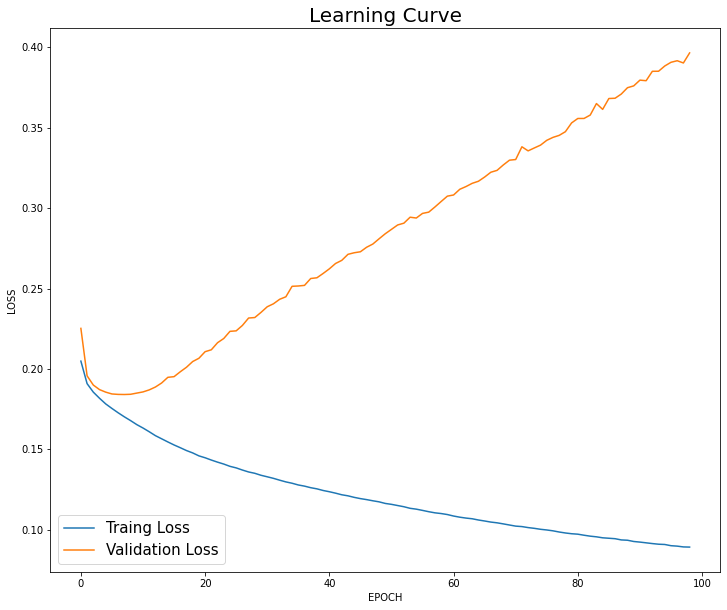

In [67]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_loss, label='Traing Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('EPOCH', size='10')
plt.ylabel('LOSS', size='10')
plt.title('Learning Curve', size='20')
plt.legend(loc='lower left', fontsize=15)

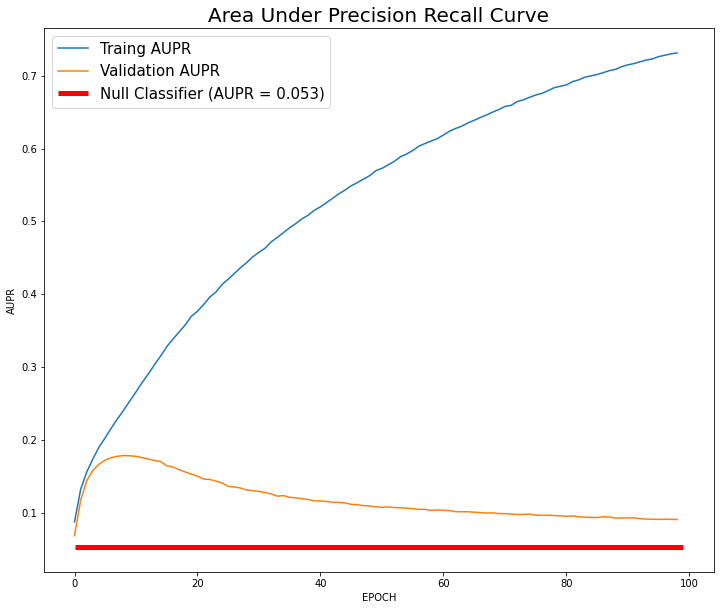

In [68]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_aupr, label='Traing AUPR')
plt.plot(validation_aupr, label='Validation AUPR')
plt.hlines(0.053, 0.0, 99.0, colors='red', label="Null Classifier (AUPR = 0.053)", linewidth=5)
plt.xlabel('EPOCH', size='10')
plt.ylabel('AUPR', size='10')
plt.title('Area Under Precision Recall Curve', size='20')
plt.legend(loc='upper left', fontsize=15)

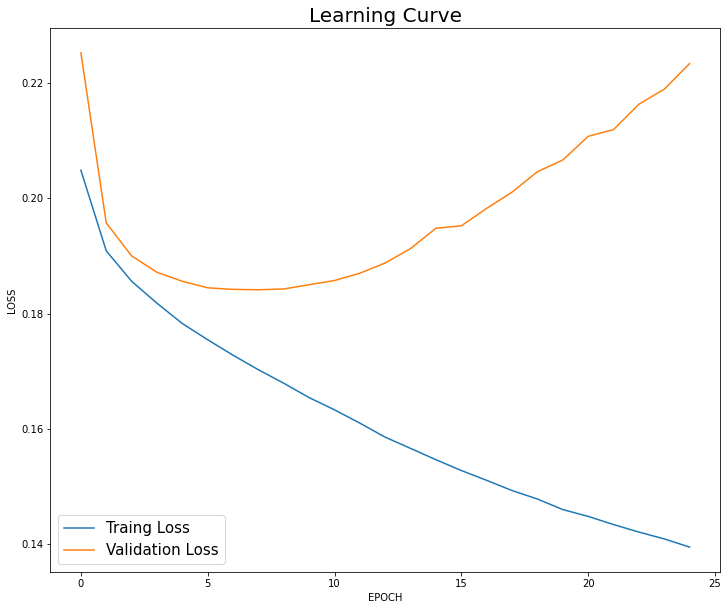

In [69]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_loss[:25], label='Traing Loss')
plt.plot(validation_loss[0:25], label='Validation Loss')
plt.xlabel('EPOCH', size='10')
plt.ylabel('LOSS', size='10')
plt.title('Learning Curve', size='20')
plt.legend(loc='lower left', fontsize=15)

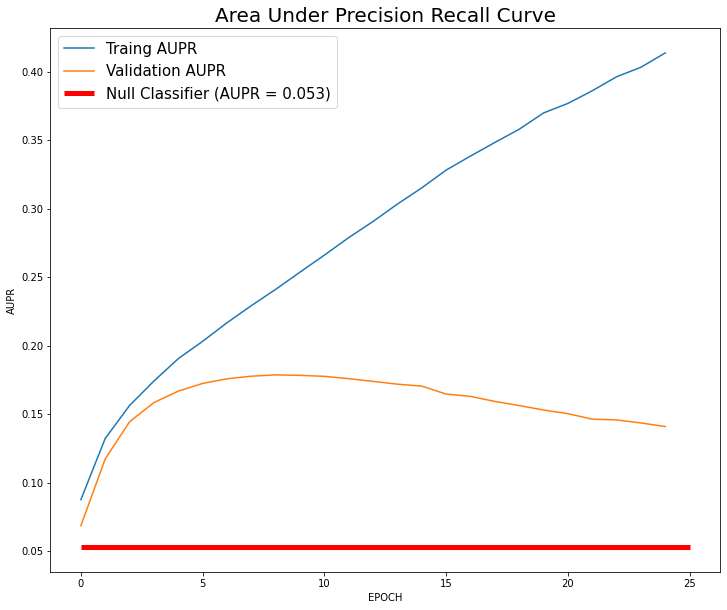

In [70]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_aupr[:25], label='Traing AUPR')
plt.plot(validation_aupr[:25], label='Validation AUPR')
plt.hlines(0.053, 0.0, 25.0, colors='red', label="Null Classifier (AUPR = 0.053)", linewidth=5)
plt.xlabel('EPOCH', size='10')
plt.ylabel('AUPR', size='10')
plt.title('Area Under Precision Recall Curve', size='20')
plt.legend(loc='upper left', fontsize=15)

# Now we  double our data size and add an early stopping callback

### Let's only  20% of the data

In [71]:
feature_table_subset = feature_table.groupby('LABEL').sample(frac=0.2, random_state=3)

In [72]:
len(feature_table), len(feature_table_subset)

(5800999, 1160200)

### Now split the data into train and test

In [73]:
X_train, X_test, y_train, y_test = train_test_split(feature_table_subset[['TYPE_SENTENCE', 'NAME_SENTENCE', 'CATEGORY_SENTENCE', 'ACTION_SENTENCE', 'LABEL_SENTENCE', 'DWELL_SENTENCE']], 
                                                    feature_table_subset['LABEL'], 
                                                    test_size=0.10, random_state=1, stratify=feature_table_subset['LABEL'])

In [74]:
X_train.head(10)

TYPE_SENTENCE  \
1980200  home, L3                                                                  
3618322  PRODUCT                                                                   
1383265  L3, L3, L3, L3, L3, L3, L3, search                                        
4855271  home, generic, L2                                                         
2547025  PRODUCT                                                                   
2068666  home                                                                      
4034215  L3                                                                        
627775   home, home, home, search                                                  
4713940  home, search, search                                                      
750064   home, home, search, search, PRODUCT, PRODUCT, PRODUCT, PRODUCT, PRODUCT   

                                                                                                                                                                                                      NAME_SENTENCE  \
1980200  Homepage, AirFiltersResults                                                                                                                                                                                  
3618322  HubAndBearingMountingBolts                                                                                                                                                                                   
1383265  BrakePadsampShoesResults, BrakePadsampShoesResults, BrakePadsampShoesResults, BrakePadsampShoesResults, BrakePadsampShoesResults, BrakePadsampShoesResults, BrakePadsampShoesResults, headlightbulbResults   
4855271  Homepage, generic, ShocksampStrutsResults                                                                                                                                                                    
2547025  SuspensionControlArmandBallJointAssembly                                                                                                                                                                     
2068666  Homepage                                                                                                                                                                                                     
4034215  WindshieldWiperBladesResults                                                                                                                                                                                 
627775   Homepage, Homepage, Homepage, coilResults                                                                                                                                                                    
4713940  Homepage, BrakelineconnectorsResults, BrakelineconnectorsResults                                                                                                                                             
750064   Homepage, Homepage, powerinverterResults, powerinverterResults, 800WattHighPowerInverter, 800WattHighPowerInverter, 800WattHighPowerInverter, 800WattHighPowerInverter, 800WattHighPowerInverter             

                                                                                                                                                            CATEGORY_SENTENCE  \
1980200  HomePage, Header                                                                                                                                                       
3618322  ProductDetailPage                                                                                                                                                      
1383265  FacetedBrowsing, Header, Header, FacetedBrowsing, ProductListPage, ProductListPage, UnbxdSearch, ProductListPage                                                       
4855271  Header, GlobalFooter, ProductListPage                      

### Split data into list of labels and 5 lists of features

In [75]:
X_train_type = X_train['TYPE_SENTENCE'].tolist()
X_test_type = X_test['TYPE_SENTENCE'].tolist()
X_train_name = X_train['NAME_SENTENCE'].tolist()
X_test_name = X_test['NAME_SENTENCE'].tolist()
X_train_category = X_train['CATEGORY_SENTENCE'].tolist()
X_test_category = X_test['CATEGORY_SENTENCE'].tolist()
X_train_action = X_train['ACTION_SENTENCE'].tolist()
X_test_action = X_test['ACTION_SENTENCE'].tolist()
X_train_label = X_train['LABEL_SENTENCE'].tolist()
X_test_label = X_test['LABEL_SENTENCE'].tolist()
X_train_dwell = X_train['DWELL_SENTENCE'].tolist()
X_test_dwell = X_test['DWELL_SENTENCE'].tolist()

In [76]:
X_train_type[0]

'home, L3'

In [77]:
X_train_name[0]

'Homepage, AirFiltersResults'

In [78]:
X_train_label[0]

'C30183, ReactAddaVehicleOptionspageinitialized'

In [79]:
X_train_dwell[0]

'30, 20'

In [40]:
y_train.head()

5335719    0
2030801    0
5431150    0
2011192    1
3798751    1
Name: LABEL, dtype: int32

In [80]:
tokenizer = Tokenizer(
    num_words=400,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, 
    split=', ', 
    char_level=False, 
    oov_token="UNKNOWN")

### Prepare sequences for modeling.  Note that we pass the fit tokenizer when we prepare the test sequences

#### We create an empty dictionary.  The keys will be the sentence name, the values will be the train and test indicies

In [81]:
data_dict = {}

In [82]:
vocab_size_dict = {'TYPE_SENTENCE': 50,
                   'NAME_SENTENCE': 40000,
                   'CATEGORY_SENTENCE': 1900,
                   'ACTION_SENTENCE': 20000,
                   'LABEL_SENTENCE': 40000,
                   'DWELL_SENTENCE': 11
                  }

In [83]:
for column_name, size in vocab_size_dict.items():
    print(f'Starting {column_name} with size {size}')
    data_dict[column_name] = {}
    data_dict[column_name]['train'], fit_tokenizer = process_sentences(sentence_series=X_train[column_name], maxlen=7, num_words=size)
    data_dict[column_name]['test'], _ = process_sentences(sentence_series=X_test[column_name], maxlen=7, tokenizer=fit_tokenizer)
    

Starting TYPE_SENTENCE with size 50
Starting NAME_SENTENCE with size 40000
Starting CATEGORY_SENTENCE with size 1900
Starting ACTION_SENTENCE with size 20000
Starting LABEL_SENTENCE with size 40000
Starting DWELL_SENTENCE with size 11


In [84]:
data_dict['DWELL_SENTENCE']['train'][:10]

array([[ 0,  0,  0,  0,  0,  1,  8],
       [ 0,  0,  0,  0,  0,  0,  1],
       [ 1,  7,  8,  4,  5,  6,  5],
       [ 0,  0,  0,  0,  1,  6, 10],
       [ 0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  1, 10,  7,  3],
       [ 0,  0,  0,  0,  1,  7,  7],
       [ 1,  4,  2,  6,  7,  8, 10]], dtype=int32)

In [85]:
data_dict['TYPE_SENTENCE']['train'][:10]

array([[ 0,  0,  0,  0,  0,  5,  6],
       [ 0,  0,  0,  0,  0,  0,  7],
       [10,  6,  6,  6,  6,  6,  6],
       [ 0,  0,  0,  0,  5, 11, 13],
       [ 0,  0,  0,  0,  0,  0,  7],
       [ 0,  0,  0,  0,  0,  0,  5],
       [ 0,  0,  0,  0,  0,  0, 10],
       [ 0,  0,  0,  5,  4,  4,  2],
       [ 0,  0,  0,  0,  5,  2,  2],
       [ 5,  4,  2,  2,  3,  3,  3]], dtype=int32)

In [86]:
data_dict['ACTION_SENTENCE']['train'][:10]

array([[   0,    0,    0,    0,    0,   17,    2],
       [   0,    0,    0,    0,    0,    0,   23],
       [  14,    2,    2,    6,    3,    3,   70],
       [   0,    0,    0,    0,   42,  376,    3],
       [   0,    0,    0,    0,    0,    0,   22],
       [   0,    0,    0,    0,    0,    0,  209],
       [   0,    0,    0,    0,    0,    0,   72],
       [   0,    0,    0,    4,    2,  375,    3],
       [   0,    0,    0,    0,    1,    3,  252],
       [1299, 1133,    3,    3,    7,   10,    7]], dtype=int32)

In [87]:
data_dict['LABEL_SENTENCE']['train'][:10]

array([[    0,     0,     0,     0,     0,   137,    11],
       [    0,     0,     0,     0,     0,     0,    38],
       [   17,    14,     8,    12,     2,     7, 13374],
       [    0,     0,     0,     0,    29,   960,     2],
       [    0,     0,     0,     0,     0,     0, 15153],
       [    0,     0,     0,     0,     0,     0,     1],
       [    0,     0,     0,     0,     0,     0,     1],
       [    0,     0,     0,    10,     8,     1,     2],
       [    0,     0,     0,     0,     5,     2,     3],
       [20609,  5586,     2,     7,  5586,    13,  5586]], dtype=int32)

In [88]:
data_dict['NAME_SENTENCE']['train'][:10]

array([[    0,     0,     0,     0,     0,     3,    20],
       [    0,     0,     0,     0,     0,     0,  2453],
       [   25,     9,     9,     9,     9,     9,     9],
       [    0,     0,     0,     0,     3,     5,   191],
       [    0,     0,     0,     0,     0,     0,  2241],
       [    0,     0,     0,     0,     0,     0,     3],
       [    0,     0,     0,     0,     0,     0,    62],
       [    0,     0,     0,     3,     2,     2,   368],
       [    0,     0,     0,     0,     3,     1,     1],
       [    3,     2,  1224,  1224, 11864, 11864, 11864]], dtype=int32)

In [89]:
data_dict['CATEGORY_SENTENCE']['train'][:10]

array([[ 0,  0,  0,  0,  0, 17,  2],
       [ 0,  0,  0,  0,  0,  0, 10],
       [15,  2,  2,  8,  3,  3,  4],
       [ 0,  0,  0,  0,  6, 28,  3],
       [ 0,  0,  0,  0,  0,  0, 10],
       [ 0,  0,  0,  0,  0,  0,  7],
       [ 0,  0,  0,  0,  0,  0, 18],
       [ 0,  0,  0,  6,  2,  4,  3],
       [ 0,  0,  0,  0,  7,  3,  4],
       [12,  4,  3,  3,  5,  5,  5]], dtype=int32)

### Our data is now fully prepared.  We now begin our modeling in keras

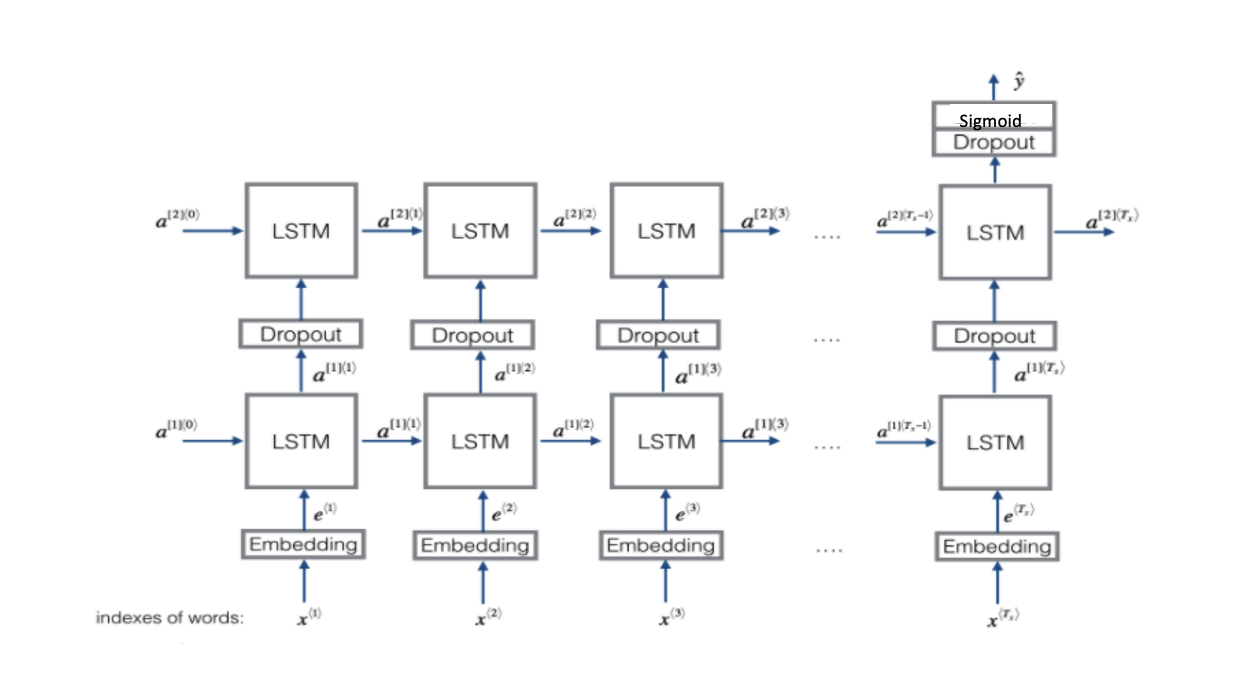

#### Above is our architecure.  We will add all layers in the architecure, but to start we will set dropout to 0.0 to start and try to minimze the training error

In [92]:
def ClickStreamPageModel(input_shape):
    """
    Function creating the click stream model using page names per the graph above
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the model
    name_sentence_indices = Input(shape=input_shape, dtype='int32')
    action_sentence_indicies = Input(shape=input_shape, dtype='int32')
    label_sentence_indicies = Input(shape=input_shape, dtype='int32')
    dwell_sentence_indicies = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layers and propogate the input through these, then append these to create a 57 dimension input
    name_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(name_sentence_indices)
    action_emb = Embedding(input_dim=20001, output_dim=25, trainable=True, mask_zero=True)(action_sentence_indicies)
    label_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(label_sentence_indicies)
    dwell_emb = Embedding(input_dim=12, output_dim=2, trainable=True, mask_zero=True)(dwell_sentence_indicies)
    X = Concatenate()([name_emb, action_emb, label_emb, dwell_emb])
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units=128, return_sequences=True)(X)
    
    # Add dropout with a probability of 0.4
    X = Dropout(rate=0.4)(X)
    
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units=128, return_sequences=False)(X)
    
    # Add dropout with a probability of 0.4
    X = Dropout(rate=0.4)(X) 
    
    # Propagate X through a Dense layer with 1 unit
    X = Dense(units=1)(X)
    # Add a sigmod activation
    X = Activation('sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[name_sentence_indices, action_sentence_indicies, label_sentence_indicies, dwell_sentence_indicies], outputs=X)
    
    return model

In [93]:
model = ClickStreamPageModel(7)

In [94]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 7)]          0           []                               
                                                                                            

In [95]:
aupr = tensorflow.keras.metrics.AUC(
    num_thresholds=50,
    curve="PR",
    summation_method="interpolation",
    name='aupr',
    dtype=None,
    thresholds=None,
    multi_label=False,
    num_labels=None,
    label_weights=None,
    from_logits=False,
)

### We define callbacks for early stopping and saving the best model

In [96]:
early_stopping_callback = tensorflow.keras.callbacks.EarlyStopping(
    monitor="val_aupr",
    min_delta=0,
    patience=4,
    verbose=0,
    mode="max",
    baseline=None,
    restore_best_weights=True,
)

In [97]:
model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-5), metrics=[aupr, 'accuracy'])

In [100]:
model.fit([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train']],
           y_train, 
           callbacks=[early_stopping_callback],
           epochs = 100, 
           batch_size = 32, 
           shuffle=True, 
           validation_split=0.5)

Epoch 1/100
16316/16316 [==============================] - 1110s 67ms/step - loss: 0.2777 - aupr: 0.0589 - accuracy: 0.9463 - val_loss: 0.1956 - val_aupr: 0.1191 - val_accuracy: 0.9465
Epoch 2/100
16316/16316 [==============================] - 1102s 68ms/step - loss: 0.1895 - aupr: 0.1419 - accuracy: 0.9467 - val_loss: 0.1866 - val_aupr: 0.1576 - val_accuracy: 0.9463
Epoch 3/100
16316/16316 [==============================] - 1100s 67ms/step - loss: 0.1831 - aupr: 0.1706 - accuracy: 0.9467 - val_loss: 0.1835 - val_aupr: 0.1712 - val_accuracy: 0.9463
Epoch 4/100
16316/16316 [==============================] - 1098s 67ms/step - loss: 0.1794 - aupr: 0.1877 - accuracy: 0.9467 - val_loss: 0.1822 - val_aupr: 0.1783 - val_accuracy: 0.9463
Epoch 5/100
16316/16316 [==============================] - 1091s 67ms/step - loss: 0.1766 - aupr: 0.2002 - accuracy: 0.9467 - val_loss: 0.1815 - val_aupr: 0.1824 - val_accuracy: 0.9464
Epoch 6/100
16316/16316 [==============================] - 1092s 67ms/step 

In [101]:
training_loss = model.history.history['loss']
validation_loss = model.history.history['val_loss']
training_aupr = model.history.history['aupr']
validation_aupr = model.history.history['val_aupr']

#### Remove the first item from the training list and the last item from the validation list.  This is due to the fact that reported training metrics are the mean of all the metrics in the epoch, but validation metrics are taken at the end of the epoch

In [102]:
validation_loss = validation_loss[:-1]

In [103]:
training_loss = training_loss[1:]

In [104]:
validation_aupr = validation_aupr[:-1]

In [105]:
training_aupr = training_aupr[1:]

In [106]:
len(validation_loss), len(training_loss), len(validation_aupr), len(training_aupr)

(11, 11, 11, 11)

In [107]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

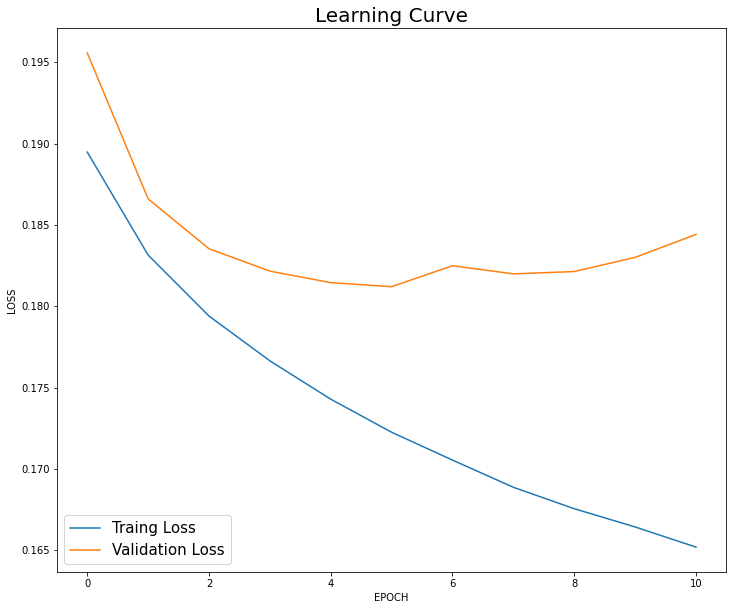

In [108]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_loss, label='Traing Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('EPOCH', size='10')
plt.ylabel('LOSS', size='10')
plt.title('Learning Curve', size='20')
plt.legend(loc='lower left', fontsize=15)

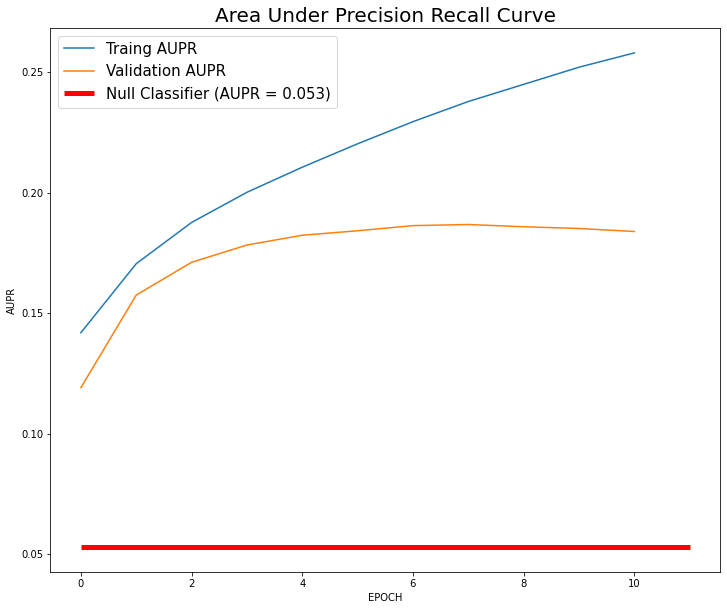

In [112]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_aupr, label='Traing AUPR')
plt.plot(validation_aupr, label='Validation AUPR')
plt.hlines(0.053, 0.0, 11.0, colors='red', label="Null Classifier (AUPR = 0.053)", linewidth=5)
plt.xlabel('EPOCH', size='10')
plt.ylabel('AUPR', size='10')
plt.title('Area Under Precision Recall Curve', size='20')
plt.legend(loc='upper left', fontsize=15)

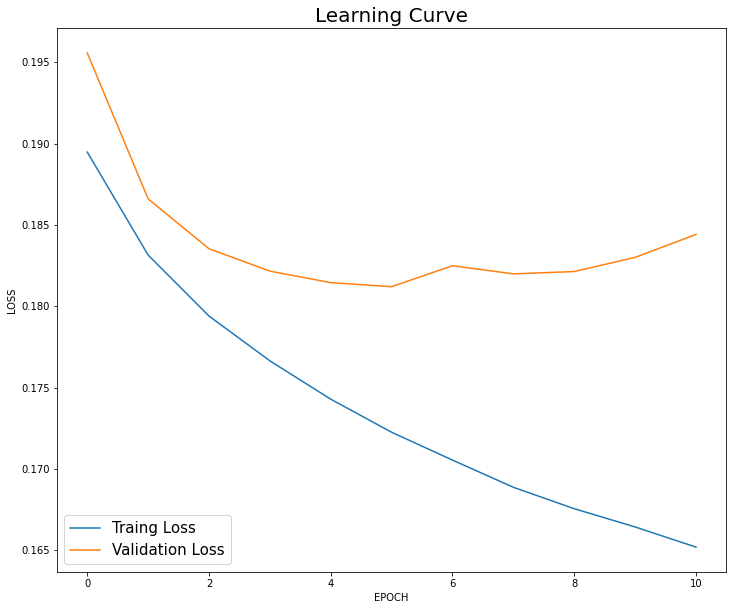

In [110]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_loss[:25], label='Traing Loss')
plt.plot(validation_loss[0:25], label='Validation Loss')
plt.xlabel('EPOCH', size='10')
plt.ylabel('LOSS', size='10')
plt.title('Learning Curve', size='20')
plt.legend(loc='lower left', fontsize=15)

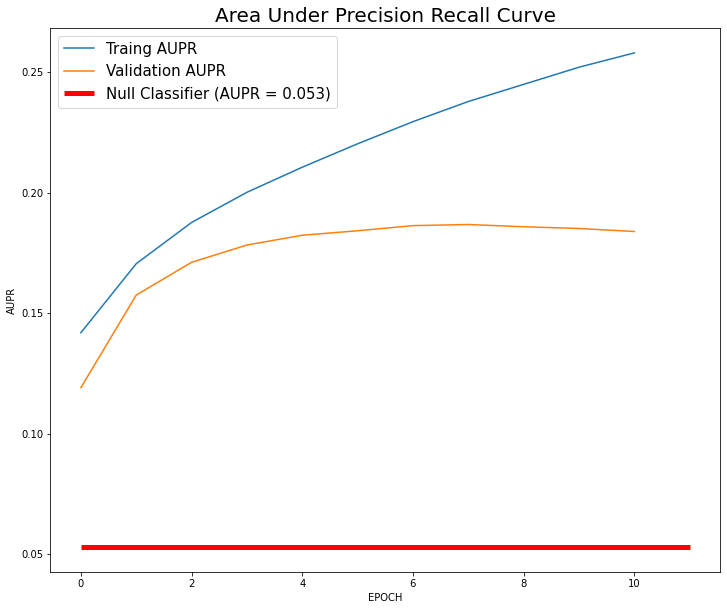

In [113]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_aupr[:25], label='Traing AUPR')
plt.plot(validation_aupr[:25], label='Validation AUPR')
plt.hlines(0.053, 0.0, 11.0, colors='red', label="Null Classifier (AUPR = 0.053)", linewidth=5)
plt.xlabel('EPOCH', size='10')
plt.ylabel('AUPR', size='10')
plt.title('Area Under Precision Recall Curve', size='20')
plt.legend(loc='upper left', fontsize=15)

In [114]:
def print_conversion_metrics(y_true, y_pred_classes, y_pred_probs, title):
    cmtx = pd.DataFrame(
    confusion_matrix(y_true=y_true, y_pred=y_pred_classes), 
                     index=['true: not converted', 'true: converted'], columns=['pred: not converted', 'pred: converted'])
    print(title)
    print(cmtx)
    print('\n')
    print(classification_report(y_true, y_pred_classes))
    print(f'The area under the PR curve is approximately {average_precision_score(y_true, y_pred_probs, pos_label=1):1.2f}')
    

In [118]:
predictions_train = model.predict([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train']])
predicted_classes_train = np.where(predictions_train > 0.5, 1, 0)

In [119]:
print_conversion_metrics(y_train, predicted_classes_train, predictions_train, 'Training Results')

Training Results
                     pred: not converted  pred: converted
true: not converted  987596               879            
true: converted      54789                916            


              precision    recall  f1-score   support

           0       0.95      1.00      0.97    988475
           1       0.51      0.02      0.03     55705

    accuracy                           0.95   1044180
   macro avg       0.73      0.51      0.50   1044180
weighted avg       0.92      0.95      0.92   1044180

The area under the PR curve is approximately 0.22


#### Confusion matrix for training  is as expected

#### Now we create the confustion matrix for test

In [122]:
predictions_test = model.predict([data_dict['NAME_SENTENCE']['test'], 
           data_dict['ACTION_SENTENCE']['test'],
           data_dict['LABEL_SENTENCE']['test'],
           data_dict['DWELL_SENTENCE']['test']])


In [130]:
predicted_classes_test = np.where(predictions_test > 0.17, 1, 0)

In [131]:
print_conversion_metrics(y_test, predicted_classes_test, predictions_test, 'Test Results')

Test Results
                     pred: not converted  pred: converted
true: not converted  104910               4921           
true: converted      4554                 1635           


              precision    recall  f1-score   support

           0       0.96      0.96      0.96    109831
           1       0.25      0.26      0.26      6189

    accuracy                           0.92    116020
   macro avg       0.60      0.61      0.61    116020
weighted avg       0.92      0.92      0.92    116020

The area under the PR curve is approximately 0.19


### Now we slow things down by increasinng droput

In [132]:
def ClickStreamPageModel(input_shape):
    """
    Function creating the click stream model using page names per the graph above
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the model
    name_sentence_indices = Input(shape=input_shape, dtype='int32')
    action_sentence_indicies = Input(shape=input_shape, dtype='int32')
    label_sentence_indicies = Input(shape=input_shape, dtype='int32')
    dwell_sentence_indicies = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layers and propogate the input through these, then append these to create a 57 dimension input
    name_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(name_sentence_indices)
    action_emb = Embedding(input_dim=20001, output_dim=25, trainable=True, mask_zero=True)(action_sentence_indicies)
    label_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(label_sentence_indicies)
    dwell_emb = Embedding(input_dim=12, output_dim=2, trainable=True, mask_zero=True)(dwell_sentence_indicies)
    X = Concatenate()([name_emb, action_emb, label_emb, dwell_emb])
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units=128, return_sequences=True)(X)
    
    # Add dropout with a probability of 0.2
    X = Dropout(rate=0.2)(X)
    
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units=128, return_sequences=False)(X)
    
    # Add dropout with a probability of 0.2
    X = Dropout(rate=0.2)(X) 
    
    # Propagate X through a Dense layer with 1 unit
    X = Dense(units=1)(X)
    # Add a sigmod activation
    X = Activation('sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[name_sentence_indices, action_sentence_indicies, label_sentence_indicies, dwell_sentence_indicies], outputs=X)
    
    return model

In [133]:
model = ClickStreamPageModel(7)

In [134]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 7)]          0           []                               
                                                                                            

In [135]:
aupr = tensorflow.keras.metrics.AUC(
    num_thresholds=50,
    curve="PR",
    summation_method="interpolation",
    name='aupr',
    dtype=None,
    thresholds=None,
    multi_label=False,
    num_labels=None,
    label_weights=None,
    from_logits=False,
)

### We define callbacks for early stopping and saving the best model

In [136]:
early_stopping_callback = tensorflow.keras.callbacks.EarlyStopping(
    monitor="val_aupr",
    min_delta=0,
    patience=4,
    verbose=0,
    mode="max",
    baseline=None,
    restore_best_weights=True,
)

In [137]:
model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-5), metrics=[aupr, 'accuracy'])

In [138]:
model.fit([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train']],
           y_train, 
           callbacks=[early_stopping_callback],
           epochs = 100, 
           batch_size = 32, 
           shuffle=True, 
           validation_split=0.5)

Epoch 1/100
16316/16316 [==============================] - 1123s 68ms/step - loss: 0.2754 - aupr: 0.0582 - accuracy: 0.9464 - val_loss: 0.1944 - val_aupr: 0.1196 - val_accuracy: 0.9465
Epoch 2/100
16316/16316 [==============================] - 1108s 68ms/step - loss: 0.1881 - aupr: 0.1458 - accuracy: 0.9467 - val_loss: 0.1861 - val_aupr: 0.1593 - val_accuracy: 0.9464
Epoch 3/100
16316/16316 [==============================] - 1109s 68ms/step - loss: 0.1818 - aupr: 0.1757 - accuracy: 0.9467 - val_loss: 0.1830 - val_aupr: 0.1741 - val_accuracy: 0.9464
Epoch 4/100
16316/16316 [==============================] - 1107s 68ms/step - loss: 0.1781 - aupr: 0.1927 - accuracy: 0.9468 - val_loss: 0.1814 - val_aupr: 0.1814 - val_accuracy: 0.9464
Epoch 5/100
16316/16316 [==============================] - 1096s 67ms/step - loss: 0.1754 - aupr: 0.2047 - accuracy: 0.9468 - val_loss: 0.1807 - val_aupr: 0.1850 - val_accuracy: 0.9464
Epoch 6/100
16316/16316 [==============================] - 1108s 68ms/step 

In [139]:
training_loss = model.history.history['loss']
validation_loss = model.history.history['val_loss']
training_aupr = model.history.history['aupr']
validation_aupr = model.history.history['val_aupr']

#### Remove the first item from the training list and the last item from the validation list.  This is due to the fact that reported training metrics are the mean of all the metrics in the epoch, but validation metrics are taken at the end of the epoch

In [140]:
validation_loss = validation_loss[:-1]

In [141]:
training_loss = training_loss[1:]

In [142]:
validation_aupr = validation_aupr[:-1]

In [143]:
training_aupr = training_aupr[1:]

In [144]:
len(validation_loss), len(training_loss), len(validation_aupr), len(training_aupr)

(10, 10, 10, 10)

In [145]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

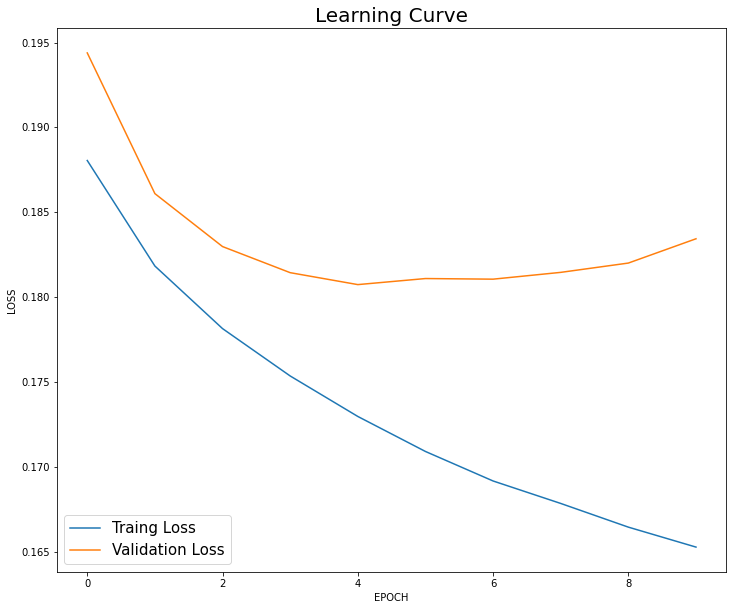

In [146]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_loss, label='Traing Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('EPOCH', size='10')
plt.ylabel('LOSS', size='10')
plt.title('Learning Curve', size='20')
plt.legend(loc='lower left', fontsize=15)

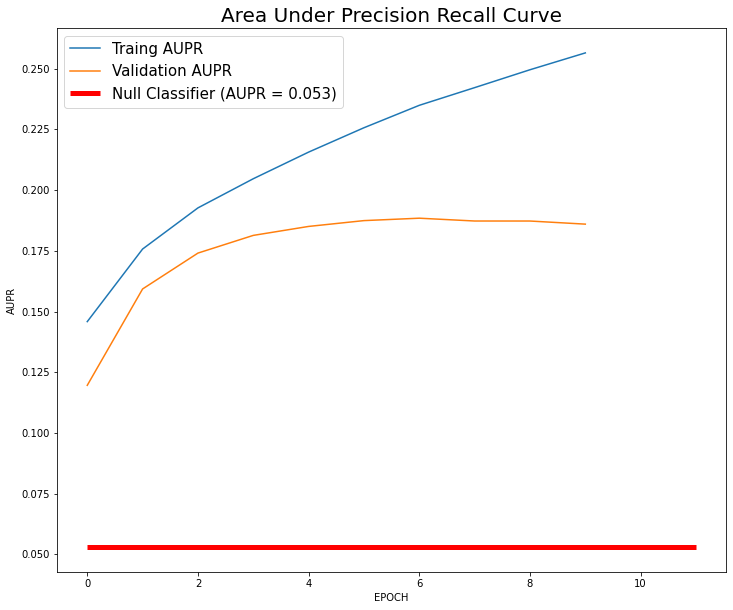

In [147]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_aupr, label='Traing AUPR')
plt.plot(validation_aupr, label='Validation AUPR')
plt.hlines(0.053, 0.0, 11.0, colors='red', label="Null Classifier (AUPR = 0.053)", linewidth=5)
plt.xlabel('EPOCH', size='10')
plt.ylabel('AUPR', size='10')
plt.title('Area Under Precision Recall Curve', size='20')
plt.legend(loc='upper left', fontsize=15)

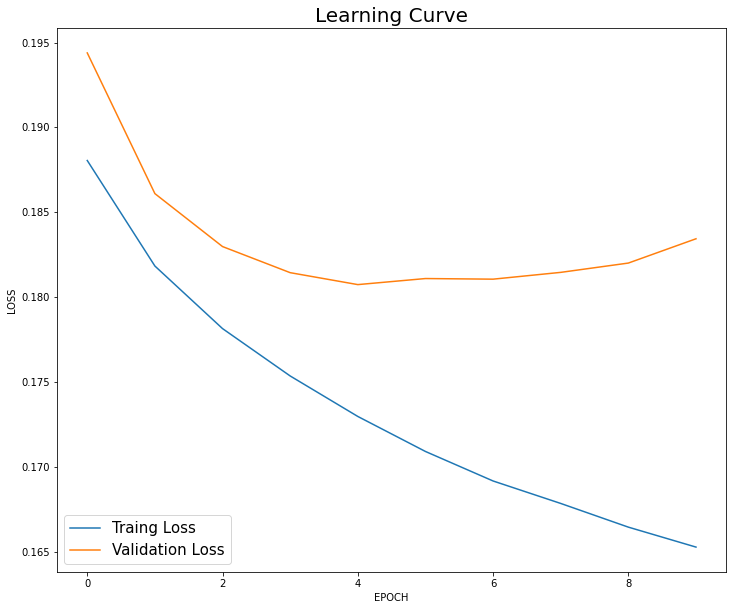

In [148]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_loss[:25], label='Traing Loss')
plt.plot(validation_loss[0:25], label='Validation Loss')
plt.xlabel('EPOCH', size='10')
plt.ylabel('LOSS', size='10')
plt.title('Learning Curve', size='20')
plt.legend(loc='lower left', fontsize=15)

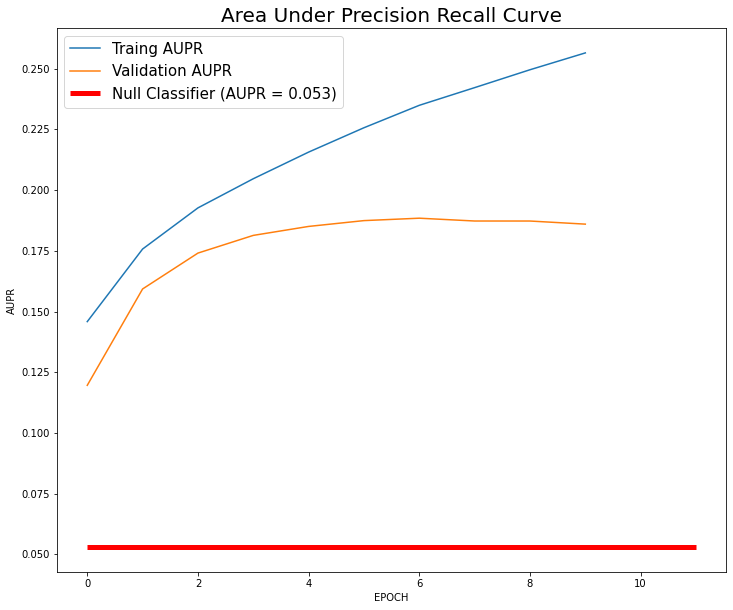

In [149]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_aupr[:25], label='Traing AUPR')
plt.plot(validation_aupr[:25], label='Validation AUPR')
plt.hlines(0.053, 0.0, 11.0, colors='red', label="Null Classifier (AUPR = 0.053)", linewidth=5)
plt.xlabel('EPOCH', size='10')
plt.ylabel('AUPR', size='10')
plt.title('Area Under Precision Recall Curve', size='20')
plt.legend(loc='upper left', fontsize=15)

In [150]:
def print_conversion_metrics(y_true, y_pred_classes, y_pred_probs, title):
    cmtx = pd.DataFrame(
    confusion_matrix(y_true=y_true, y_pred=y_pred_classes), 
                     index=['true: not converted', 'true: converted'], columns=['pred: not converted', 'pred: converted'])
    print(title)
    print(cmtx)
    print('\n')
    print(classification_report(y_true, y_pred_classes))
    print(f'The area under the PR curve is approximately {average_precision_score(y_true, y_pred_probs, pos_label=1):1.2f}')
    

In [151]:
predictions_train = model.predict([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train']])
predicted_classes_train = np.where(predictions_train > 0.5, 1, 0)

In [152]:
print_conversion_metrics(y_train, predicted_classes_train, predictions_train, 'Training Results')

Training Results
                     pred: not converted  pred: converted
true: not converted  987644               831            
true: converted      54856                849            


              precision    recall  f1-score   support

           0       0.95      1.00      0.97    988475
           1       0.51      0.02      0.03     55705

    accuracy                           0.95   1044180
   macro avg       0.73      0.51      0.50   1044180
weighted avg       0.92      0.95      0.92   1044180

The area under the PR curve is approximately 0.21


#### Confusion matrix for training  is as expected

#### Now we create the confustion matrix for test

In [153]:
predictions_test = model.predict([data_dict['NAME_SENTENCE']['test'], 
           data_dict['ACTION_SENTENCE']['test'],
           data_dict['LABEL_SENTENCE']['test'],
           data_dict['DWELL_SENTENCE']['test']])


In [158]:
predicted_classes_test = np.where(predictions_test > 0.19, 1, 0)

In [159]:
print_conversion_metrics(y_test, predicted_classes_test, predictions_test, 'Test Results')

Test Results
                     pred: not converted  pred: converted
true: not converted  105682               4149           
true: converted      4722                 1467           


              precision    recall  f1-score   support

           0       0.96      0.96      0.96    109831
           1       0.26      0.24      0.25      6189

    accuracy                           0.92    116020
   macro avg       0.61      0.60      0.60    116020
weighted avg       0.92      0.92      0.92    116020

The area under the PR curve is approximately 0.19


### Now more data

# Now we  double our data size again and reset droput to 0.4

### Let's only  40% of the data

In [160]:
feature_table_subset = feature_table.groupby('LABEL').sample(frac=0.4, random_state=3)

In [161]:
len(feature_table), len(feature_table_subset)

(5800999, 2320400)

### Now split the data into train and test

In [162]:
X_train, X_test, y_train, y_test = train_test_split(feature_table_subset[['TYPE_SENTENCE', 'NAME_SENTENCE', 'CATEGORY_SENTENCE', 'ACTION_SENTENCE', 'LABEL_SENTENCE', 'DWELL_SENTENCE']], 
                                                    feature_table_subset['LABEL'], 
                                                    test_size=0.10, random_state=1, stratify=feature_table_subset['LABEL'])

In [163]:
X_train.head(10)

TYPE_SENTENCE  \
2357946  home, home, home                                                                                                                                                                                                                                         
5406632  reactsearch, home, L3, L3, L4, L4                                                                                                                                                                                                                        
3278493  home, home, search                                                                                                                                                                                                                                       
1906283  store, store, store, L3                                                                                                                                                                                                                                  
293338   L2, search                                                                                                                                                                                                                                               
4780241  reactsearch, search, search, search, search, reactsearch, PRODUCT, search, search, search, search, search, search, search, search, search, generic, generic, PRODUCT, PRODUCT, PRODUCT, search, search, search, search, search, search, search, search   
5782076  home, home, home                                                                                                                                                                                                                                         
5515728  home, search, search, search, search                                                                                                                                                                                                                     
3561519  PRODUCT, PRODUCT, PRODUCT, PRODUCT, PRODUCT, PRODUCT, search, PRODUCT, reactsearch, search                                                                                                                                                               
157271   L3                                                                                                                                                                                                                                                       

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             NAME_SENTENCE  \
2357946  Homepage, Homepage, Homepage                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
5406632  reactsearch, Homepage, CarBatteriesResults, CarBatteriesResults, BatteryResults, BatteryResults                                                                                                                                                                            

### Split data into list of labels and 5 lists of features

In [164]:
X_train_type = X_train['TYPE_SENTENCE'].tolist()
X_test_type = X_test['TYPE_SENTENCE'].tolist()
X_train_name = X_train['NAME_SENTENCE'].tolist()
X_test_name = X_test['NAME_SENTENCE'].tolist()
X_train_category = X_train['CATEGORY_SENTENCE'].tolist()
X_test_category = X_test['CATEGORY_SENTENCE'].tolist()
X_train_action = X_train['ACTION_SENTENCE'].tolist()
X_test_action = X_test['ACTION_SENTENCE'].tolist()
X_train_label = X_train['LABEL_SENTENCE'].tolist()
X_test_label = X_test['LABEL_SENTENCE'].tolist()
X_train_dwell = X_train['DWELL_SENTENCE'].tolist()
X_test_dwell = X_test['DWELL_SENTENCE'].tolist()

In [165]:
X_train_type[0]

'home, home, home'

In [166]:
X_train_name[0]

'Homepage, Homepage, Homepage'

In [167]:
X_train_label[0]

'ReactAddaVehicleOptionspageinitialized, AddaVehicleComplete, DuplicateAddaVehicleComplete'

In [168]:
X_train_dwell[0]

'50, 10, 50'

In [169]:
y_train.head()

2357946    0
5406632    0
3278493    0
1906283    0
293338     0
Name: LABEL, dtype: int32

In [170]:
tokenizer = Tokenizer(
    num_words=400,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, 
    split=', ', 
    char_level=False, 
    oov_token="UNKNOWN")

### Prepare sequences for modeling.  Note that we pass the fit tokenizer when we prepare the test sequences

#### We create an empty dictionary.  The keys will be the sentence name, the values will be the train and test indicies

In [171]:
data_dict = {}

In [172]:
vocab_size_dict = {'TYPE_SENTENCE': 50,
                   'NAME_SENTENCE': 40000,
                   'CATEGORY_SENTENCE': 1900,
                   'ACTION_SENTENCE': 20000,
                   'LABEL_SENTENCE': 40000,
                   'DWELL_SENTENCE': 11
                  }

In [173]:
for column_name, size in vocab_size_dict.items():
    print(f'Starting {column_name} with size {size}')
    data_dict[column_name] = {}
    data_dict[column_name]['train'], fit_tokenizer = process_sentences(sentence_series=X_train[column_name], maxlen=7, num_words=size)
    data_dict[column_name]['test'], _ = process_sentences(sentence_series=X_test[column_name], maxlen=7, tokenizer=fit_tokenizer)
    

Starting TYPE_SENTENCE with size 50
Starting NAME_SENTENCE with size 40000
Starting CATEGORY_SENTENCE with size 1900
Starting ACTION_SENTENCE with size 20000
Starting LABEL_SENTENCE with size 40000
Starting DWELL_SENTENCE with size 11


In [174]:
data_dict['DWELL_SENTENCE']['train'][:10]

array([[ 0,  0,  0,  0,  1,  2,  9],
       [ 0,  1,  3,  6, 10,  3, 10],
       [ 0,  0,  0,  0,  1,  9,  9],
       [ 0,  0,  0,  1,  7,  6,  6],
       [ 0,  0,  0,  0,  0,  1,  6],
       [ 1, 10,  3,  8,  3,  6,  9],
       [ 0,  0,  0,  0,  1,  9,  3],
       [ 0,  0,  1,  2,  8,  3,  6],
       [ 1,  3,  8,  3,  3,  7,  8],
       [ 0,  0,  0,  0,  0,  0,  1]], dtype=int32)

In [175]:
data_dict['TYPE_SENTENCE']['train'][:10]

array([[ 0,  0,  0,  0,  5,  4,  4],
       [ 0, 12,  4,  6,  6, 14, 14],
       [ 0,  0,  0,  0,  5,  4,  2],
       [ 0,  0,  0, 16,  8,  8,  6],
       [ 0,  0,  0,  0,  0, 17,  2],
       [12,  2,  2,  2,  2,  9,  3],
       [ 0,  0,  0,  0,  5,  4,  4],
       [ 0,  0,  5,  2,  2,  2,  2],
       [ 7,  3,  3,  3,  3,  3,  2],
       [ 0,  0,  0,  0,  0,  0, 10]], dtype=int32)

In [176]:
data_dict['ACTION_SENTENCE']['train'][:10]

array([[   0,    0,    0,    0,    4,    2,    2],
       [   0, 2500,   15,    3,   51,    3,    3],
       [   0,    0,    0,    0,  310,   78,    2],
       [   0,    0,    0,    4,    2,  304,    9],
       [   0,    0,    0,    0,    0, 1265,    3],
       [5538,    9,    9,    6,    5, 1773, 1773],
       [   0,    0,    0,    0,    4,    2,    2],
       [   0,    0,  495,    2,    2,    2,    2],
       [   4,    2,    2,   11,    7,  106,   12],
       [   0,    0,    0,    0,    0,    0,   14]], dtype=int32)

In [177]:
data_dict['LABEL_SENTENCE']['train'][:10]

array([[    0,     0,     0,     0,     9,     8,    40],
       [    0,     1,    68,     2,    18,     2,     7],
       [    0,     0,     0,     0,     5,     3,    14],
       [    0,     0,     0,    10,     8, 23624,    55],
       [    0,     0,     0,     0,     0,     1,     2],
       [    5,    25,    28,   155,     1,  7469,  7469],
       [    0,     0,     0,     0,     9,     4,     6],
       [    0,     0,     5,    11,     4,    11,     6],
       [    9,     4,     6, 30764, 13656, 13656,    15],
       [    0,     0,     0,     0,     0,     0,    17]], dtype=int32)

In [178]:
data_dict['NAME_SENTENCE']['train'][:10]

array([[   0,    0,    0,    0,    3,    2,    2],
       [   0,    8,    2,   10,   10,   34,   34],
       [   0,    0,    0,    0,    3,    2,   59],
       [   0,    0,    0,  155,   14,   14,   13],
       [   0,    0,    0,    0,    0, 1556,  897],
       [   8, 2860, 2860, 2860, 2860,    4,   55],
       [   0,    0,    0,    0,    3,    2,    2],
       [   0,    0,    3,   73,   73,   73,   73],
       [1636,  744,  744,  744, 6313,  744,  138],
       [   0,    0,    0,    0,    0,    0,   65]], dtype=int32)

In [179]:
data_dict['CATEGORY_SENTENCE']['train'][:10]

array([[ 0,  0,  0,  0,  6, 11,  2],
       [ 0,  7, 11,  3, 19,  3,  3],
       [ 0,  0,  0,  0, 12,  4,  2],
       [ 0,  0,  0,  6,  2, 13,  3],
       [ 0,  0,  0,  0,  0,  7,  3],
       [ 7,  3,  3,  8,  3,  4,  4],
       [ 0,  0,  0,  0,  6,  2,  2],
       [ 0,  0,  7,  2,  2,  2,  2],
       [ 6,  2,  2,  5,  5,  4,  3],
       [ 0,  0,  0,  0,  0,  0, 15]], dtype=int32)

### Our data is now fully prepared.  We now begin our modeling in keras

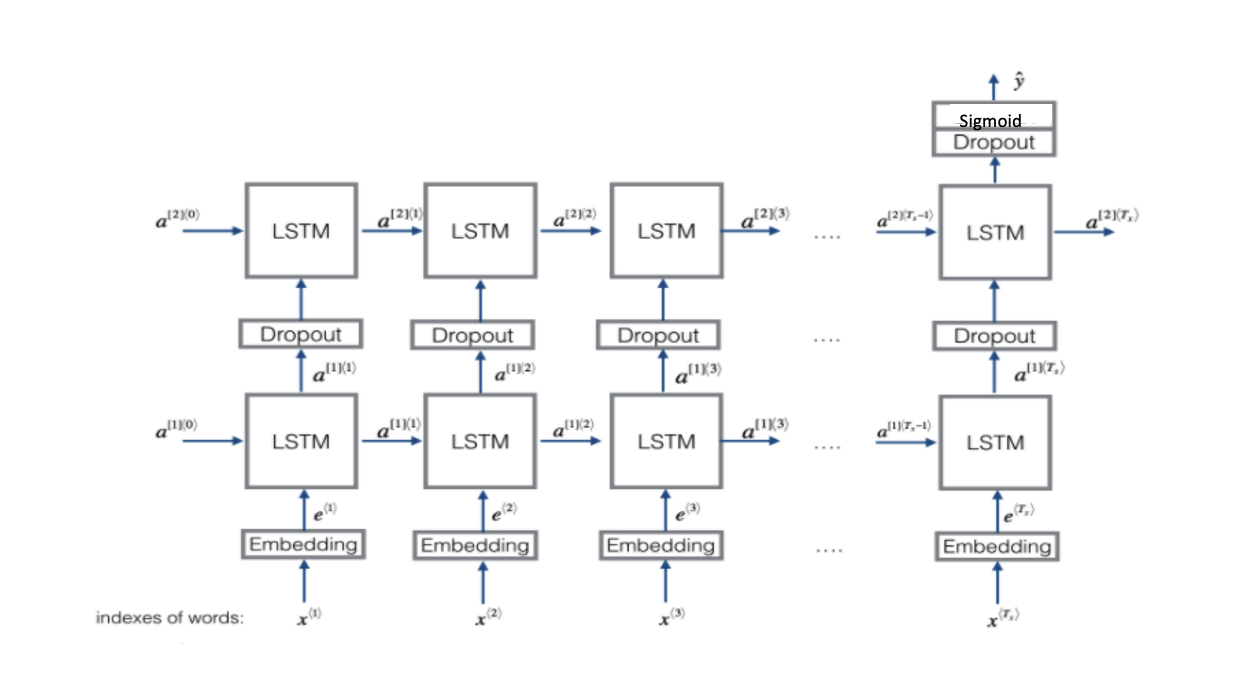

#### Above is our architecure.  We will add all layers in the architecure, but to start we will set dropout to 0.0 to start and try to minimze the training error

In [180]:
def ClickStreamPageModel(input_shape):
    """
    Function creating the click stream model using page names per the graph above
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the model
    name_sentence_indices = Input(shape=input_shape, dtype='int32')
    action_sentence_indicies = Input(shape=input_shape, dtype='int32')
    label_sentence_indicies = Input(shape=input_shape, dtype='int32')
    dwell_sentence_indicies = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layers and propogate the input through these, then append these to create a 57 dimension input
    name_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(name_sentence_indices)
    action_emb = Embedding(input_dim=20001, output_dim=25, trainable=True, mask_zero=True)(action_sentence_indicies)
    label_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(label_sentence_indicies)
    dwell_emb = Embedding(input_dim=12, output_dim=2, trainable=True, mask_zero=True)(dwell_sentence_indicies)
    X = Concatenate()([name_emb, action_emb, label_emb, dwell_emb])
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units=128, return_sequences=True)(X)
    
    # Add dropout with a probability of 0.4
    X = Dropout(rate=0.4)(X)
    
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units=128, return_sequences=False)(X)
    
    # Add dropout with a probability of 0.4
    X = Dropout(rate=0.4)(X) 
    
    # Propagate X through a Dense layer with 1 unit
    X = Dense(units=1)(X)
    # Add a sigmod activation
    X = Activation('sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[name_sentence_indices, action_sentence_indicies, label_sentence_indicies, dwell_sentence_indicies], outputs=X)
    
    return model

In [181]:
model = ClickStreamPageModel(7)

In [182]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 7)]          0           []                               
                                                                                            

In [183]:
aupr = tensorflow.keras.metrics.AUC(
    num_thresholds=50,
    curve="PR",
    summation_method="interpolation",
    name='aupr',
    dtype=None,
    thresholds=None,
    multi_label=False,
    num_labels=None,
    label_weights=None,
    from_logits=False,
)

### We define callbacks for early stopping and saving the best model

In [184]:
early_stopping_callback = tensorflow.keras.callbacks.EarlyStopping(
    monitor="val_aupr",
    min_delta=0,
    patience=4,
    verbose=0,
    mode="max",
    baseline=None,
    restore_best_weights=True,
)

In [185]:
model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-5), metrics=[aupr, 'accuracy'])

In [186]:
model.fit([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train']],
           y_train, 
           callbacks=[early_stopping_callback],
           epochs = 100, 
           batch_size = 32, 
           shuffle=True, 
           validation_split=0.5)

Epoch 1/100
32631/32631 [==============================] - 2205s 67ms/step - loss: 0.2351 - aupr: 0.0721 - accuracy: 0.9465 - val_loss: 0.1865 - val_aupr: 0.1552 - val_accuracy: 0.9464
Epoch 2/100
32631/32631 [==============================] - 2193s 67ms/step - loss: 0.1833 - aupr: 0.1706 - accuracy: 0.9466 - val_loss: 0.1816 - val_aupr: 0.1774 - val_accuracy: 0.9464
Epoch 3/100
32631/32631 [==============================] - 2194s 67ms/step - loss: 0.1791 - aupr: 0.1894 - accuracy: 0.9466 - val_loss: 0.1796 - val_aupr: 0.1864 - val_accuracy: 0.9464
Epoch 4/100
32631/32631 [==============================] - 2193s 67ms/step - loss: 0.1766 - aupr: 0.2010 - accuracy: 0.9466 - val_loss: 0.1790 - val_aupr: 0.1906 - val_accuracy: 0.9464
Epoch 5/100
32631/32631 [==============================] - 2175s 67ms/step - loss: 0.1748 - aupr: 0.2094 - accuracy: 0.9467 - val_loss: 0.1789 - val_aupr: 0.1941 - val_accuracy: 0.9465
Epoch 6/100
32631/32631 [==============================] - 2160s 66ms/step 

In [187]:
training_loss = model.history.history['loss']
validation_loss = model.history.history['val_loss']
training_aupr = model.history.history['aupr']
validation_aupr = model.history.history['val_aupr']

#### Remove the first item from the training list and the last item from the validation list.  This is due to the fact that reported training metrics are the mean of all the metrics in the epoch, but validation metrics are taken at the end of the epoch

In [188]:
validation_loss = validation_loss[:-1]

In [189]:
training_loss = training_loss[1:]

In [190]:
validation_aupr = validation_aupr[:-1]

In [191]:
training_aupr = training_aupr[1:]

In [192]:
len(validation_loss), len(training_loss), len(validation_aupr), len(training_aupr)

(14, 14, 14, 14)

In [193]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

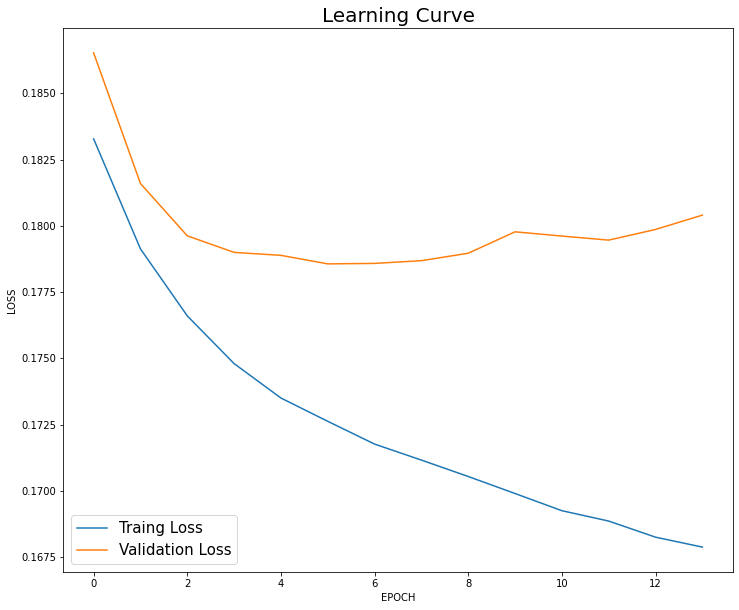

In [194]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_loss, label='Traing Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('EPOCH', size='10')
plt.ylabel('LOSS', size='10')
plt.title('Learning Curve', size='20')
plt.legend(loc='lower left', fontsize=15)

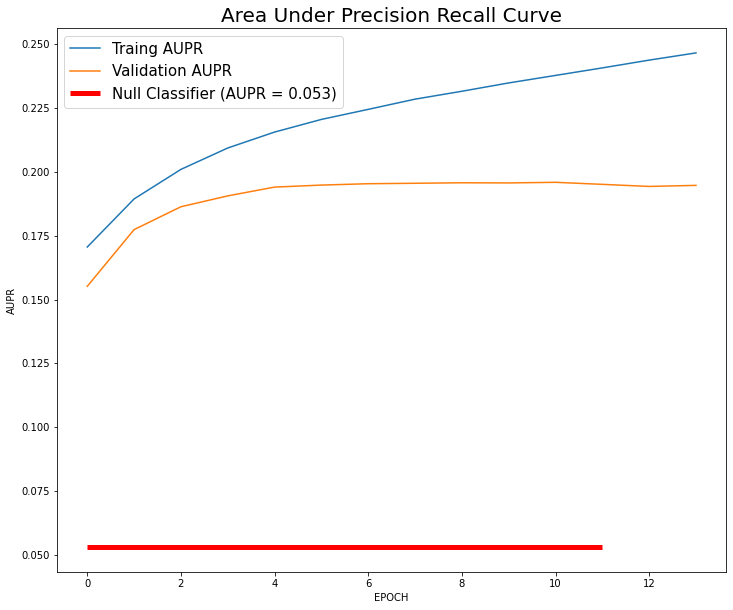

In [195]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_aupr, label='Traing AUPR')
plt.plot(validation_aupr, label='Validation AUPR')
plt.hlines(0.053, 0.0, 11.0, colors='red', label="Null Classifier (AUPR = 0.053)", linewidth=5)
plt.xlabel('EPOCH', size='10')
plt.ylabel('AUPR', size='10')
plt.title('Area Under Precision Recall Curve', size='20')
plt.legend(loc='upper left', fontsize=15)

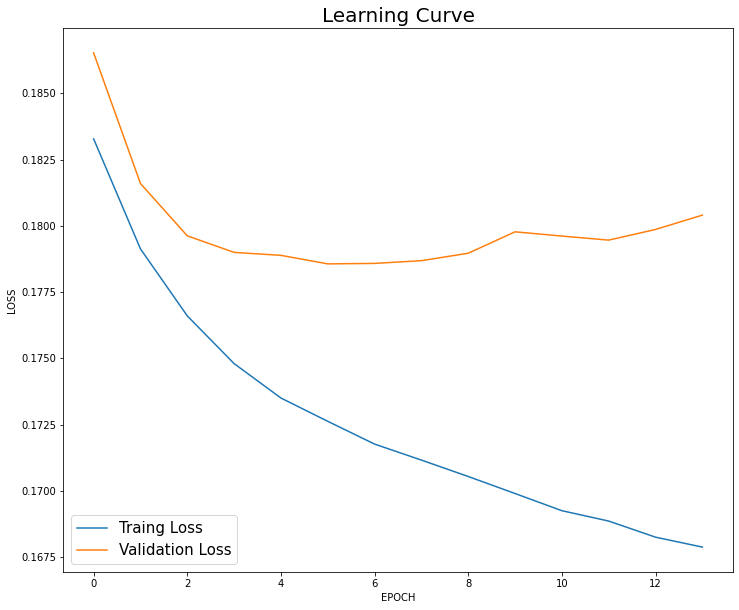

In [196]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_loss[:25], label='Traing Loss')
plt.plot(validation_loss[0:25], label='Validation Loss')
plt.xlabel('EPOCH', size='10')
plt.ylabel('LOSS', size='10')
plt.title('Learning Curve', size='20')
plt.legend(loc='lower left', fontsize=15)

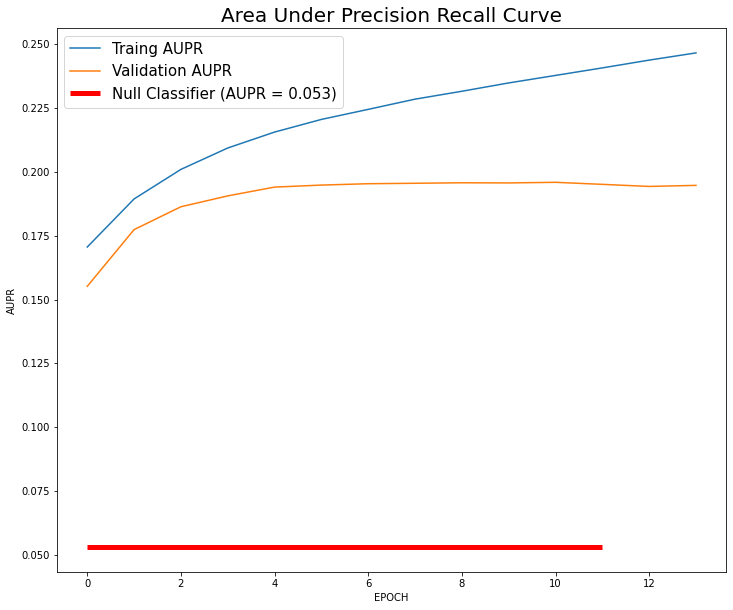

In [197]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_aupr[:25], label='Traing AUPR')
plt.plot(validation_aupr[:25], label='Validation AUPR')
plt.hlines(0.053, 0.0, 11.0, colors='red', label="Null Classifier (AUPR = 0.053)", linewidth=5)
plt.xlabel('EPOCH', size='10')
plt.ylabel('AUPR', size='10')
plt.title('Area Under Precision Recall Curve', size='20')
plt.legend(loc='upper left', fontsize=15)

In [198]:
def print_conversion_metrics(y_true, y_pred_classes, y_pred_probs, title):
    cmtx = pd.DataFrame(
    confusion_matrix(y_true=y_true, y_pred=y_pred_classes), 
                     index=['true: not converted', 'true: converted'], columns=['pred: not converted', 'pred: converted'])
    print(title)
    print(cmtx)
    print('\n')
    print(classification_report(y_true, y_pred_classes))
    print(f'The area under the PR curve is approximately {average_precision_score(y_true, y_pred_probs, pos_label=1):1.2f}')
    

In [199]:
predictions_train = model.predict([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train']])
predicted_classes_train = np.where(predictions_train > 0.5, 1, 0)

In [200]:
print_conversion_metrics(y_train, predicted_classes_train, predictions_train, 'Training Results')

Training Results
                     pred: not converted  pred: converted
true: not converted  1974922              2029           
true: converted      109272               2137           


              precision    recall  f1-score   support

           0       0.95      1.00      0.97   1976951
           1       0.51      0.02      0.04    111409

    accuracy                           0.95   2088360
   macro avg       0.73      0.51      0.50   2088360
weighted avg       0.92      0.95      0.92   2088360

The area under the PR curve is approximately 0.22


#### Confusion matrix for training  is as expected

#### Now we create the confustion matrix for test

In [201]:
predictions_test = model.predict([data_dict['NAME_SENTENCE']['test'], 
           data_dict['ACTION_SENTENCE']['test'],
           data_dict['LABEL_SENTENCE']['test'],
           data_dict['DWELL_SENTENCE']['test']])


In [206]:
predicted_classes_test = np.where(predictions_test > 0.18, 1, 0)

In [207]:
print_conversion_metrics(y_test, predicted_classes_test, predictions_test, 'Test Results')

Test Results
                     pred: not converted  pred: converted
true: not converted  210117               9544           
true: converted      9244                 3135           


              precision    recall  f1-score   support

           0       0.96      0.96      0.96    219661
           1       0.25      0.25      0.25     12379

    accuracy                           0.92    232040
   macro avg       0.60      0.60      0.60    232040
weighted avg       0.92      0.92      0.92    232040

The area under the PR curve is approximately 0.20


### Now we use all the data

In [208]:
feature_table_subset = feature_table

In [209]:
len(feature_table), len(feature_table_subset)

(5800999, 5800999)

### Now split the data into train and test

In [210]:
X_train, X_test, y_train, y_test = train_test_split(feature_table_subset[['TYPE_SENTENCE', 'NAME_SENTENCE', 'CATEGORY_SENTENCE', 'ACTION_SENTENCE', 'LABEL_SENTENCE', 'DWELL_SENTENCE']], 
                                                    feature_table_subset['LABEL'], 
                                                    test_size=0.10, random_state=1, stratify=feature_table_subset['LABEL'])

In [211]:
X_train.head(10)

TYPE_SENTENCE  \
915790   L3, store, store                                                                      
2496776  home, home, home, home, search                                                        
759501   PRODUCT, store, store, store, store                                                   
5385614  home, home, home                                                                      
2479679  home, home, home, search, reactsearch, search, PRODUCT, PRODUCT                       
3409004  home, home, home, home, search, search, generic, generic, generic, generic, generic   
3866716  home, home, home                                                                      
1926733  PRODUCT, PRODUCT, PRODUCT, reactsearch, search, search, search                        
2441837  L2                                                                                    
1883044  PRODUCT, PRODUCT                                                                      

                                                                                                                                                                            NAME_SENTENCE  \
915790   CarBatteriesResults, StoreLocator, StoreLocator                                                                                                                                    
2496776  Homepage, Homepage, Homepage, Homepage, universaljointsResults                                                                                                                     
759501   VentvisorDeflector4pcSmoke, StoreLocator, StoreLocator, StoreLocator, StoreLocator                                                                                                 
5385614  Homepage, Homepage, Homepage                                                                                                                                                       
2479679  Homepage, Homepage, Homepage, brakewheelcylinderResults, reactsearch, brakewheelcylinderResults, DrumBrakeWheelCylinder, DrumBrakeWheelCylinder                                    
3409004  Homepage, Homepage, Homepage, Homepage, discbrakepadandrotorkitResults, discbrakepadandrotorkitResults, generic, generic, generic, generic, generic                                
3866716  Homepage, Homepage, Homepage                                                                                                                                                       
1926733  UltraShineHeadlightRestorationWipes6count, HRKSystem1EASYLVN, HRKSystem1EASYLVN, reactsearch, finalclearancepromoResults, finalclearancepromoResults, finalclearancepromoResults   
2441837  AirFiltersampRelatedResults                                                                                                                                                        
1883044  RotellaT4TripleProtection15W40ConventionalHeavyDutyDieselEngineOil1Gallon, RotellaT4TripleProtection15W40ConventionalHeavyDutyDieselEngineOil1Gallon                               

                                                                                                                                                      CATEGORY_SENTENCE  \
915790   Header, Header, Header                                                                                                                                           
2496776  Header, Header, Header, UnbxdSearch, ProductListPage                                                                                                             
759501   Header, Header, Header, Header, UnbxdSearchAutoSuggest                                                                                                           
5385614  Header, Header, Header                                                                                                                                           
2479679  Header, Header, UnbxdSearchAutoSuggest, ProductListPage, UnbxdSearch, ProductL

### Split data into list of labels and 5 lists of features

In [212]:
X_train_type = X_train['TYPE_SENTENCE'].tolist()
X_test_type = X_test['TYPE_SENTENCE'].tolist()
X_train_name = X_train['NAME_SENTENCE'].tolist()
X_test_name = X_test['NAME_SENTENCE'].tolist()
X_train_category = X_train['CATEGORY_SENTENCE'].tolist()
X_test_category = X_test['CATEGORY_SENTENCE'].tolist()
X_train_action = X_train['ACTION_SENTENCE'].tolist()
X_test_action = X_test['ACTION_SENTENCE'].tolist()
X_train_label = X_train['LABEL_SENTENCE'].tolist()
X_test_label = X_test['LABEL_SENTENCE'].tolist()
X_train_dwell = X_train['DWELL_SENTENCE'].tolist()
X_test_dwell = X_test['DWELL_SENTENCE'].tolist()

In [213]:
X_train_type[0]

'L3, store, store'

In [214]:
X_train_name[0]

'CarBatteriesResults, StoreLocator, StoreLocator'

In [215]:
X_train_label[0]

'HeaderOpenStoreLocator, AddaVehicleStart, AddaVehicleComplete'

In [216]:
X_train_dwell[0]

'60, 70, 50'

In [217]:
y_train.head()

915790     0
2496776    0
759501     0
5385614    0
2479679    0
Name: LABEL, dtype: int32

In [218]:
tokenizer = Tokenizer(
    num_words=400,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, 
    split=', ', 
    char_level=False, 
    oov_token="UNKNOWN")

### Prepare sequences for modeling.  Note that we pass the fit tokenizer when we prepare the test sequences

#### We create an empty dictionary.  The keys will be the sentence name, the values will be the train and test indicies

In [219]:
data_dict = {}

In [220]:
vocab_size_dict = {'TYPE_SENTENCE': 50,
                   'NAME_SENTENCE': 40000,
                   'CATEGORY_SENTENCE': 1900,
                   'ACTION_SENTENCE': 20000,
                   'LABEL_SENTENCE': 40000,
                   'DWELL_SENTENCE': 11
                  }

In [221]:
for column_name, size in vocab_size_dict.items():
    print(f'Starting {column_name} with size {size}')
    data_dict[column_name] = {}
    data_dict[column_name]['train'], fit_tokenizer = process_sentences(sentence_series=X_train[column_name], maxlen=7, num_words=size)
    data_dict[column_name]['test'], _ = process_sentences(sentence_series=X_test[column_name], maxlen=7, tokenizer=fit_tokenizer)
    

Starting TYPE_SENTENCE with size 50
Starting NAME_SENTENCE with size 40000
Starting CATEGORY_SENTENCE with size 1900
Starting ACTION_SENTENCE with size 20000
Starting LABEL_SENTENCE with size 40000
Starting DWELL_SENTENCE with size 11


In [222]:
data_dict['DWELL_SENTENCE']['train'][:10]

array([[ 0,  0,  0,  0,  1,  5,  9],
       [ 0,  0,  1,  9,  3,  5,  6],
       [ 0,  0,  1,  2,  4,  7,  8],
       [ 0,  0,  0,  0,  1,  5,  9],
       [ 1,  3,  4,  3,  9,  5, 10],
       [ 1, 10,  9,  3,  5,  3,  2],
       [ 0,  0,  0,  0,  1,  5, 10],
       [ 1,  5,  8, 10,  8,  5,  9],
       [ 0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  1,  4]], dtype=int32)

In [223]:
data_dict['TYPE_SENTENCE']['train'][:10]

array([[ 0,  0,  0,  0, 10,  8,  8],
       [ 0,  0,  5,  4,  4,  4,  2],
       [ 0,  0,  7,  8,  8,  8,  8],
       [ 0,  0,  0,  0,  5,  4,  4],
       [ 5,  4,  4,  2,  9,  2,  3],
       [ 5,  4,  4,  4,  2,  2, 11],
       [ 0,  0,  0,  0,  5,  4,  4],
       [ 7,  3,  3,  9,  2,  2,  2],
       [ 0,  0,  0,  0,  0,  0, 17],
       [ 0,  0,  0,  0,  0,  7,  3]], dtype=int32)

In [224]:
data_dict['ACTION_SENTENCE']['train'][:10]

array([[   0,    0,    0,    0,   20,    2,    2],
       [   0,    0,   37,    2,    2,  278,    3],
       [   0,    0,   20,    2,    2,    2, 2077],
       [   0,    0,    0,    0,   37,    2,    2],
       [   4,    2,  462,    5,  462,    5,    8],
       [  17,   15,   47,  149,    2,    2,  149],
       [   0,    0,    0,    0,    4,    2,    2],
       [  99,   11,   64,   54,    3,    3, 2385],
       [   0,    0,    0,    0,    0,    0,   14],
       [   0,    0,    0,    0,    0,   24,   10]], dtype=int32)

In [225]:
data_dict['LABEL_SENTENCE']['train'][:10]

array([[    0,     0,     0,     0,    26,    14,     8],
       [    0,     0,    44,     4,     6, 29438,     2],
       [    0,     0,    63,    11,     4,     6, 24493],
       [    0,     0,     0,     0,    77,    33,    20],
       [   10,     8,     1,     1,     1,     1,    24],
       [   70,    45,     3,     3,    14,     8,  1215],
       [    0,     0,     0,     0,     9,     4,     6],
       [    1, 21436,   151,     3,     2,     7,     3],
       [    0,     0,     0,     0,     0,     0,    17],
       [    0,     0,     0,     0,     0,    29,    13]], dtype=int32)

In [226]:
data_dict['NAME_SENTENCE']['train'][:10]

array([[    0,     0,     0,     0,    18,     6,     6],
       [    0,     0,     3,     2,     2,     2,   348],
       [    0,     0,   414,     6,     6,     6,     6],
       [    0,     0,     0,     0,     3,     2,     2],
       [    3,     2,     2,   924,     4,   924,   424],
       [    3,     2,     2,     2,   293,   293,     5],
       [    0,     0,     0,     0,     3,     2,     2],
       [16211,  4207,  4207,     4,    25,    25,    25],
       [    0,     0,     0,     0,     0,     0,  2463],
       [    0,     0,     0,     0,     0, 14185,  7525]], dtype=int32)

In [227]:
data_dict['CATEGORY_SENTENCE']['train'][:10]

array([[ 0,  0,  0,  0,  6,  2,  2],
       [ 0,  0,  6,  2,  2,  4,  3],
       [ 0,  0,  6,  2,  2,  2,  9],
       [ 0,  0,  0,  0,  6,  2,  2],
       [ 6,  2,  9,  3,  4,  3,  5],
       [17, 11,  9,  9,  2,  2,  9],
       [ 0,  0,  0,  0,  6,  2,  2],
       [23,  5,  2,  4,  3,  3, 13],
       [ 0,  0,  0,  0,  0,  0, 15],
       [ 0,  0,  0,  0,  0,  6,  5]], dtype=int32)

### Our data is now fully prepared.  We now begin our modeling in keras

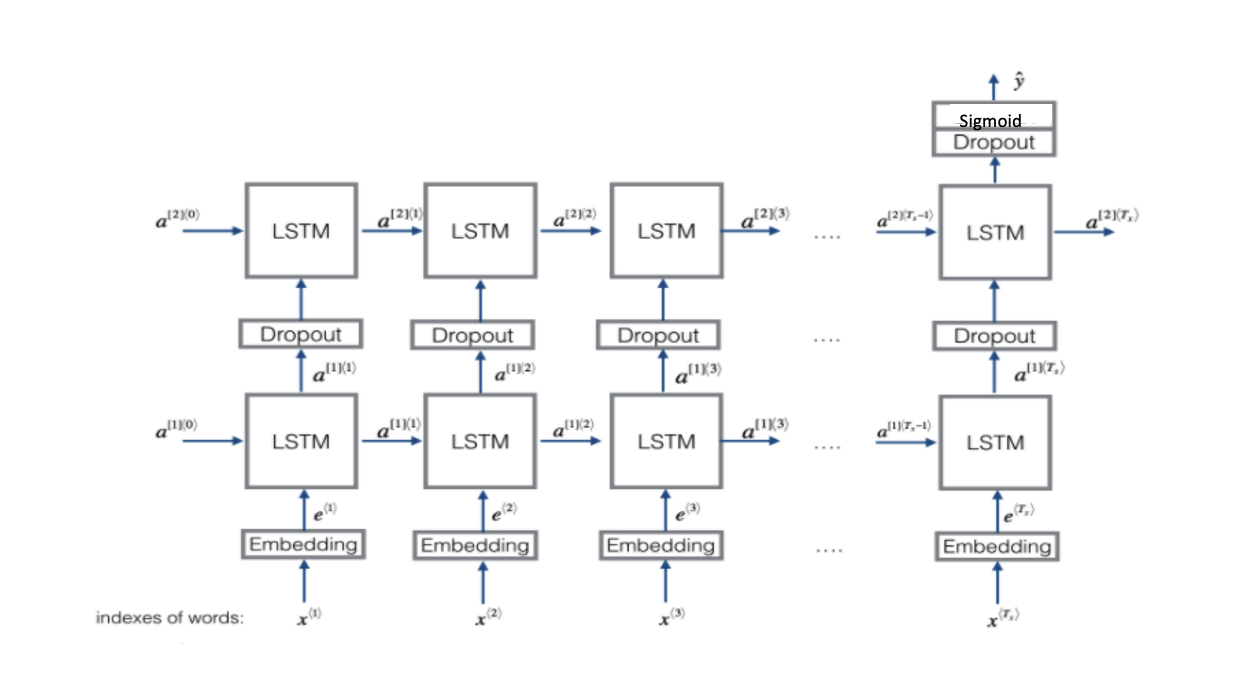

#### Above is our architecure.  We will add all layers in the architecure, but to start we will set dropout to 0.0 to start and try to minimze the training error

In [228]:
def ClickStreamPageModel(input_shape):
    """
    Function creating the click stream model using page names per the graph above
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the model
    name_sentence_indices = Input(shape=input_shape, dtype='int32')
    action_sentence_indicies = Input(shape=input_shape, dtype='int32')
    label_sentence_indicies = Input(shape=input_shape, dtype='int32')
    dwell_sentence_indicies = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layers and propogate the input through these, then append these to create a 57 dimension input
    name_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(name_sentence_indices)
    action_emb = Embedding(input_dim=20001, output_dim=25, trainable=True, mask_zero=True)(action_sentence_indicies)
    label_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(label_sentence_indicies)
    dwell_emb = Embedding(input_dim=12, output_dim=2, trainable=True, mask_zero=True)(dwell_sentence_indicies)
    X = Concatenate()([name_emb, action_emb, label_emb, dwell_emb])
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units=128, return_sequences=True)(X)
    
    # Add dropout with a probability of 0.4
    X = Dropout(rate=0.4)(X)
    
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units=128, return_sequences=False)(X)
    
    # Add dropout with a probability of 0.4
    X = Dropout(rate=0.4)(X) 
    
    # Propagate X through a Dense layer with 1 unit
    X = Dense(units=1)(X)
    # Add a sigmod activation
    X = Activation('sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[name_sentence_indices, action_sentence_indicies, label_sentence_indicies, dwell_sentence_indicies], outputs=X)
    
    return model

In [229]:
model = ClickStreamPageModel(7)

In [230]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 7)]          0           []                               
                                                                                            

In [231]:
aupr = tensorflow.keras.metrics.AUC(
    num_thresholds=50,
    curve="PR",
    summation_method="interpolation",
    name='aupr',
    dtype=None,
    thresholds=None,
    multi_label=False,
    num_labels=None,
    label_weights=None,
    from_logits=False,
)

### We define callbacks for early stopping and saving the best model

In [232]:
early_stopping_callback = tensorflow.keras.callbacks.EarlyStopping(
    monitor="val_aupr",
    min_delta=0,
    patience=4,
    verbose=0,
    mode="max",
    baseline=None,
    restore_best_weights=True,
)

In [233]:
model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-5), metrics=[aupr, 'accuracy'])

In [ ]:
model.fit([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train']],
           y_train, 
           callbacks=[early_stopping_callback],
           epochs = 100, 
           batch_size = 32, 
           shuffle=True, 
           validation_split=0.5)

Epoch 1/100
81577/81577 [==============================] - 5510s 67ms/step - loss: 0.2052 - aupr: 0.1031 - accuracy: 0.9462 - val_loss: 0.1792 - val_aupr: 0.1858 - val_accuracy: 0.9467
Epoch 2/100
81577/81577 [==============================] - 5504s 67ms/step - loss: 0.1791 - aupr: 0.1936 - accuracy: 0.9463 - val_loss: 0.1764 - val_aupr: 0.1988 - val_accuracy: 0.9469
Epoch 3/100
81577/81577 [==============================] - 5501s 67ms/step - loss: 0.1768 - aupr: 0.2042 - accuracy: 0.9464 - val_loss: 0.1757 - val_aupr: 0.2032 - val_accuracy: 0.9469
Epoch 4/100
81577/81577 [==============================] - 5505s 67ms/step - loss: 0.1757 - aupr: 0.2098 - accuracy: 0.9464 - val_loss: 0.1753 - val_aupr: 0.2054 - val_accuracy: 0.9469
Epoch 5/100
81577/81577 [==============================] - 5521s 68ms/step - loss: 0.1750 - aupr: 0.2136 - accuracy: 0.9465 - val_loss: 0.1751 - val_aupr: 0.2071 - val_accuracy: 0.9470
Epoch 6/100
81577/81577 [==============================] - 5504s 67ms/step 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



81577/81577 [==============================] - 5521s 68ms/step - loss: 0.1712 - aupr: 0.2347 - accuracy: 0.9467 - val_loss: 0.1740 - val_aupr: 0.2143 - val_accuracy: 0.9470
Epoch 16/100
81577/81577 [==============================] - 5511s 68ms/step - loss: 0.1709 - aupr: 0.2363 - accuracy: 0.9467 - val_loss: 0.1741 - val_aupr: 0.2144 - val_accuracy: 0.9470
Epoch 17/100
29031/81577 [=========>....................] - ETA: 51:31 - loss: 0.1707 - aupr: 0.2390 - accuracy: 0.9467

In [ ]:
training_loss = model.history.history['loss']
validation_loss = model.history.history['val_loss']
training_aupr = model.history.history['aupr']
validation_aupr = model.history.history['val_aupr']

#### Remove the first item from the training list and the last item from the validation list.  This is due to the fact that reported training metrics are the mean of all the metrics in the epoch, but validation metrics are taken at the end of the epoch

In [ ]:
validation_loss = validation_loss[:-1]

In [ ]:
training_loss = training_loss[1:]

In [ ]:
validation_aupr = validation_aupr[:-1]

In [ ]:
training_aupr = training_aupr[1:]

In [ ]:
len(validation_loss), len(training_loss), len(validation_aupr), len(training_aupr)

In [ ]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [ ]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_loss, label='Traing Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('EPOCH', size='10')
plt.ylabel('LOSS', size='10')
plt.title('Learning Curve', size='20')
plt.legend(loc='lower left', fontsize=15)

In [ ]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_aupr, label='Traing AUPR')
plt.plot(validation_aupr, label='Validation AUPR')
plt.hlines(0.053, 0.0, 11.0, colors='red', label="Null Classifier (AUPR = 0.053)", linewidth=5)
plt.xlabel('EPOCH', size='10')
plt.ylabel('AUPR', size='10')
plt.title('Area Under Precision Recall Curve', size='20')
plt.legend(loc='upper left', fontsize=15)

In [ ]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_loss[:25], label='Traing Loss')
plt.plot(validation_loss[0:25], label='Validation Loss')
plt.xlabel('EPOCH', size='10')
plt.ylabel('LOSS', size='10')
plt.title('Learning Curve', size='20')
plt.legend(loc='lower left', fontsize=15)

In [ ]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_aupr[:25], label='Traing AUPR')
plt.plot(validation_aupr[:25], label='Validation AUPR')
plt.hlines(0.053, 0.0, 11.0, colors='red', label="Null Classifier (AUPR = 0.053)", linewidth=5)
plt.xlabel('EPOCH', size='10')
plt.ylabel('AUPR', size='10')
plt.title('Area Under Precision Recall Curve', size='20')
plt.legend(loc='upper left', fontsize=15)

In [ ]:
def print_conversion_metrics(y_true, y_pred_classes, y_pred_probs, title):
    cmtx = pd.DataFrame(
    confusion_matrix(y_true=y_true, y_pred=y_pred_classes), 
                     index=['true: not converted', 'true: converted'], columns=['pred: not converted', 'pred: converted'])
    print(title)
    print(cmtx)
    print('\n')
    print(classification_report(y_true, y_pred_classes))
    print(f'The area under the PR curve is approximately {average_precision_score(y_true, y_pred_probs, pos_label=1):1.2f}')
    

In [ ]:
predictions_train = model.predict([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train']])
predicted_classes_train = np.where(predictions_train > 0.5, 1, 0)

In [ ]:
print_conversion_metrics(y_train, predicted_classes_train, predictions_train, 'Training Results')

#### Confusion matrix for training  is as expected

#### Now we create the confustion matrix for test

In [ ]:
predictions_test = model.predict([data_dict['NAME_SENTENCE']['test'], 
           data_dict['ACTION_SENTENCE']['test'],
           data_dict['LABEL_SENTENCE']['test'],
           data_dict['DWELL_SENTENCE']['test']])


In [ ]:
predicted_classes_test = np.where(predictions_test > 0.18, 1, 0)

In [ ]:
print_conversion_metrics(y_test, predicted_classes_test, predictions_test, 'Test Results')

# Now we use all the data and slow the learning rate

### Now we use all the data

In [ ]:
feature_table_subset = feature_table

In [ ]:
len(feature_table), len(feature_table_subset)

### Now split the data into train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(feature_table_subset[['TYPE_SENTENCE', 'NAME_SENTENCE', 'CATEGORY_SENTENCE', 'ACTION_SENTENCE', 'LABEL_SENTENCE', 'DWELL_SENTENCE']], 
                                                    feature_table_subset['LABEL'], 
                                                    test_size=0.10, random_state=1, stratify=feature_table_subset['LABEL'])

In [ ]:
X_train.head(10)

### Split data into list of labels and 5 lists of features

In [ ]:
X_train_type = X_train['TYPE_SENTENCE'].tolist()
X_test_type = X_test['TYPE_SENTENCE'].tolist()
X_train_name = X_train['NAME_SENTENCE'].tolist()
X_test_name = X_test['NAME_SENTENCE'].tolist()
X_train_category = X_train['CATEGORY_SENTENCE'].tolist()
X_test_category = X_test['CATEGORY_SENTENCE'].tolist()
X_train_action = X_train['ACTION_SENTENCE'].tolist()
X_test_action = X_test['ACTION_SENTENCE'].tolist()
X_train_label = X_train['LABEL_SENTENCE'].tolist()
X_test_label = X_test['LABEL_SENTENCE'].tolist()
X_train_dwell = X_train['DWELL_SENTENCE'].tolist()
X_test_dwell = X_test['DWELL_SENTENCE'].tolist()

In [ ]:
X_train_type[0]

In [ ]:
X_train_name[0]

In [ ]:
X_train_label[0]

In [ ]:
X_train_dwell[0]

In [ ]:
y_train.head()

In [ ]:
tokenizer = Tokenizer(
    num_words=400,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, 
    split=', ', 
    char_level=False, 
    oov_token="UNKNOWN")

### Prepare sequences for modeling.  Note that we pass the fit tokenizer when we prepare the test sequences

#### We create an empty dictionary.  The keys will be the sentence name, the values will be the train and test indicies

In [ ]:
data_dict = {}

In [ ]:
vocab_size_dict = {'TYPE_SENTENCE': 50,
                   'NAME_SENTENCE': 40000,
                   'CATEGORY_SENTENCE': 1900,
                   'ACTION_SENTENCE': 20000,
                   'LABEL_SENTENCE': 40000,
                   'DWELL_SENTENCE': 11
                  }

In [ ]:
for column_name, size in vocab_size_dict.items():
    print(f'Starting {column_name} with size {size}')
    data_dict[column_name] = {}
    data_dict[column_name]['train'], fit_tokenizer = process_sentences(sentence_series=X_train[column_name], maxlen=7, num_words=size)
    data_dict[column_name]['test'], _ = process_sentences(sentence_series=X_test[column_name], maxlen=7, tokenizer=fit_tokenizer)
    

In [ ]:
data_dict['DWELL_SENTENCE']['train'][:10]

In [ ]:
data_dict['TYPE_SENTENCE']['train'][:10]

In [ ]:
data_dict['ACTION_SENTENCE']['train'][:10]

In [ ]:
data_dict['LABEL_SENTENCE']['train'][:10]

In [ ]:
data_dict['NAME_SENTENCE']['train'][:10]

In [ ]:
data_dict['CATEGORY_SENTENCE']['train'][:10]

### Our data is now fully prepared.  We now begin our modeling in keras

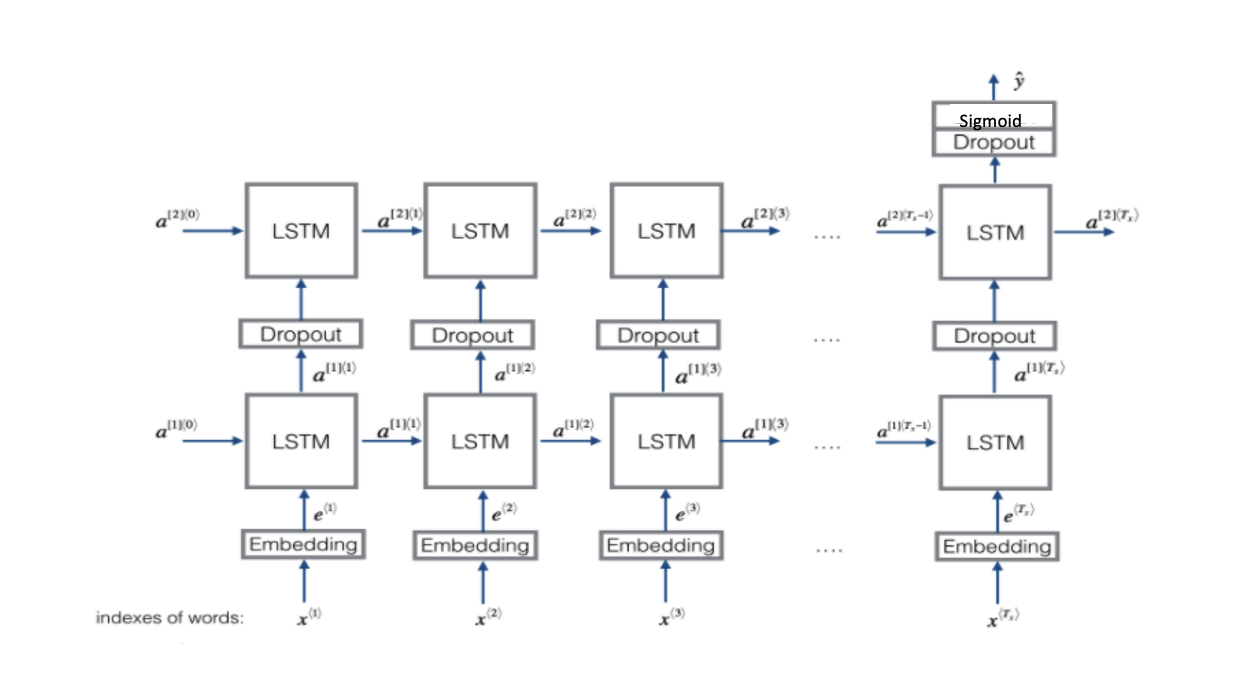

#### Above is our architecure.  We will add all layers in the architecure, but to start we will set dropout to 0.0 to start and try to minimze the training error

In [ ]:
def ClickStreamPageModel(input_shape):
    """
    Function creating the click stream model using page names per the graph above
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the model
    name_sentence_indices = Input(shape=input_shape, dtype='int32')
    action_sentence_indicies = Input(shape=input_shape, dtype='int32')
    label_sentence_indicies = Input(shape=input_shape, dtype='int32')
    dwell_sentence_indicies = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layers and propogate the input through these, then append these to create a 57 dimension input
    name_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(name_sentence_indices)
    action_emb = Embedding(input_dim=20001, output_dim=25, trainable=True, mask_zero=True)(action_sentence_indicies)
    label_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(label_sentence_indicies)
    dwell_emb = Embedding(input_dim=12, output_dim=2, trainable=True, mask_zero=True)(dwell_sentence_indicies)
    X = Concatenate()([name_emb, action_emb, label_emb, dwell_emb])
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units=128, return_sequences=True)(X)
    
    # Add dropout with a probability of 0.4
    X = Dropout(rate=0.4)(X)
    
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units=128, return_sequences=False)(X)
    
    # Add dropout with a probability of 0.4
    X = Dropout(rate=0.4)(X) 
    
    # Propagate X through a Dense layer with 1 unit
    X = Dense(units=1)(X)
    # Add a sigmod activation
    X = Activation('sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[name_sentence_indices, action_sentence_indicies, label_sentence_indicies, dwell_sentence_indicies], outputs=X)
    
    return model

In [ ]:
model = ClickStreamPageModel(7)

In [ ]:
model.summary()

In [ ]:
aupr = tensorflow.keras.metrics.AUC(
    num_thresholds=50,
    curve="PR",
    summation_method="interpolation",
    name='aupr',
    dtype=None,
    thresholds=None,
    multi_label=False,
    num_labels=None,
    label_weights=None,
    from_logits=False,
)

### We define callbacks for early stopping and saving the best model

In [ ]:
early_stopping_callback = tensorflow.keras.callbacks.EarlyStopping(
    monitor="val_aupr",
    min_delta=0,
    patience=4,
    verbose=0,
    mode="max",
    baseline=None,
    restore_best_weights=True,
)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-6), metrics=[aupr, 'accuracy'])

In [ ]:
model.fit([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train']],
           y_train, 
           callbacks=[early_stopping_callback],
           epochs = 100, 
           batch_size = 32, 
           shuffle=True, 
           validation_split=0.5)

In [ ]:
training_loss = model.history.history['loss']
validation_loss = model.history.history['val_loss']
training_aupr = model.history.history['aupr']
validation_aupr = model.history.history['val_aupr']

#### Remove the first item from the training list and the last item from the validation list.  This is due to the fact that reported training metrics are the mean of all the metrics in the epoch, but validation metrics are taken at the end of the epoch

In [ ]:
validation_loss = validation_loss[:-1]

In [ ]:
training_loss = training_loss[1:]

In [ ]:
validation_aupr = validation_aupr[:-1]

In [ ]:
training_aupr = training_aupr[1:]

In [ ]:
len(validation_loss), len(training_loss), len(validation_aupr), len(training_aupr)

In [ ]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [ ]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_loss, label='Traing Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('EPOCH', size='10')
plt.ylabel('LOSS', size='10')
plt.title('Learning Curve', size='20')
plt.legend(loc='lower left', fontsize=15)

In [ ]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_aupr, label='Traing AUPR')
plt.plot(validation_aupr, label='Validation AUPR')
plt.hlines(0.053, 0.0, 11.0, colors='red', label="Null Classifier (AUPR = 0.053)", linewidth=5)
plt.xlabel('EPOCH', size='10')
plt.ylabel('AUPR', size='10')
plt.title('Area Under Precision Recall Curve', size='20')
plt.legend(loc='upper left', fontsize=15)

In [ ]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_loss[:25], label='Traing Loss')
plt.plot(validation_loss[0:25], label='Validation Loss')
plt.xlabel('EPOCH', size='10')
plt.ylabel('LOSS', size='10')
plt.title('Learning Curve', size='20')
plt.legend(loc='lower left', fontsize=15)

In [ ]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_aupr[:25], label='Traing AUPR')
plt.plot(validation_aupr[:25], label='Validation AUPR')
plt.hlines(0.053, 0.0, 11.0, colors='red', label="Null Classifier (AUPR = 0.053)", linewidth=5)
plt.xlabel('EPOCH', size='10')
plt.ylabel('AUPR', size='10')
plt.title('Area Under Precision Recall Curve', size='20')
plt.legend(loc='upper left', fontsize=15)

In [ ]:
def print_conversion_metrics(y_true, y_pred_classes, y_pred_probs, title):
    cmtx = pd.DataFrame(
    confusion_matrix(y_true=y_true, y_pred=y_pred_classes), 
                     index=['true: not converted', 'true: converted'], columns=['pred: not converted', 'pred: converted'])
    print(title)
    print(cmtx)
    print('\n')
    print(classification_report(y_true, y_pred_classes))
    print(f'The area under the PR curve is approximately {average_precision_score(y_true, y_pred_probs, pos_label=1):1.2f}')
    

In [ ]:
predictions_train = model.predict([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train']])
predicted_classes_train = np.where(predictions_train > 0.5, 1, 0)

In [ ]:
print_conversion_metrics(y_train, predicted_classes_train, predictions_train, 'Training Results')

#### Confusion matrix for training  is as expected

#### Now we create the confustion matrix for test

In [ ]:
predictions_test = model.predict([data_dict['NAME_SENTENCE']['test'], 
           data_dict['ACTION_SENTENCE']['test'],
           data_dict['LABEL_SENTENCE']['test'],
           data_dict['DWELL_SENTENCE']['test']])


In [ ]:
predicted_classes_test = np.where(predictions_test > 0.18, 1, 0)

In [ ]:
print_conversion_metrics(y_test, predicted_classes_test, predictions_test, 'Test Results')